# Bitcoin Price Prediction Using Twitter Sentimental Analysis

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
import mplfinance as mpf
import seaborn as sns
from dateutil import parser

## Bitcoin Price Analysis

In [97]:
btc_data = pd.read_csv("crytpo_data.csv", index_col = 0)
btc_data.head(5)

,symbol,name,price,dayHigh,dayLow,volume,open,close,timestamp,time
_id,,,,,,,,,,
67477c998ad02b4e72f11b46,BTC,Bitcoin USD,96921.72,96962.00,91804.37,8.124583e+10,91938.32,91938.32,1732738201,2024-11-27 20:10:01.889000
67476e8a722b15343d0157f4,BTC,Bitcoin USD,96078.15,96664.20,91804.37,8.124583e+10,91938.32,91938.32,1732734600,2024-11-27 19:10:02.207000
6747607add19519ca50317d8,BTC,Bitcoin USD,96328.41,96530.48,91804.37,8.124583e+10,91938.32,91938.32,1732731000,2024-11-27 18:10:02.034000
6747526a3ef7e2188ee70bfe,BTC,Bitcoin USD,95514.40,96439.68,91804.37,8.124583e+10,91938.32,91938.32,1732727400,2024-11-27 17:10:02.088000
6747445a23efdfd7ce8dacb7,BTC,Bitcoin USD,95778.60,95960.00,91804.37,8.124583e+10,91938.32,91938.32,1732723800,2024-11-27 16:10:02.056000


In [98]:
btc_data.describe()

,price,dayHigh,dayLow,volume,open,close,timestamp
count,729.000000,729.000000,729.000000,7.290000e+02,729.000000,729.000000,7.290000e+02
mean,83536.379849,84597.927016,81695.471811,7.108863e+10,82767.179084,82767.179084,1.731428e+09
std,10787.795406,10954.365599,10609.820189,3.269491e+10,10831.622600,10831.622600,7.579677e+05
min,67403.940000,68538.000000,66783.770000,1.819931e+10,67785.195000,67785.195000,1.730132e+09
25%,72306.000000,72714.380000,69705.760000,4.551983e+10,70202.875000,70202.875000,1.730773e+09
50%,87671.530000,89600.000000,85010.000000,6.365704e+10,87305.710000,87305.710000,1.731428e+09
75%,92476.100000,93772.260000,90853.000000,8.930853e+10,91938.320000,91938.320000,1.732083e+09
max,99639.100000,99860.000000,97806.000000,1.698264e+11,99005.305000,99005.305000,1.732738e+09


In [99]:
# Drop rows with missing values
btc_data = btc_data.dropna()

# Convert the 'timestamp' column to datetime and set it as the index
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'], unit='s')
btc_data = btc_data.set_index('timestamp').sort_index()  # Sort by timestamp in ascending order

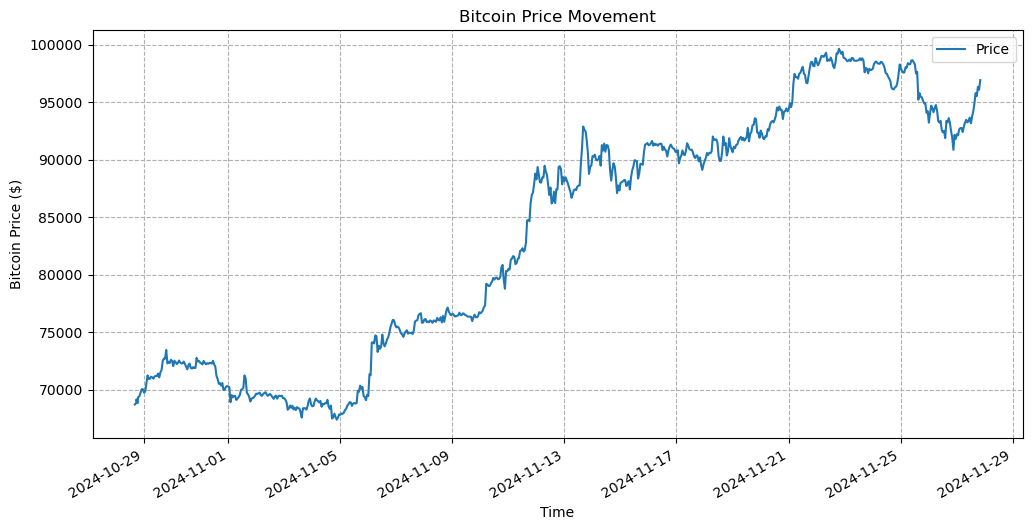

In [100]:
# Plot the Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data["price"], label="Price")
plt.xlabel('Time')
plt.ylabel('Bitcoin Price ($)')
plt.title('Bitcoin Price Movement')
plt.legend()

# Automatically format the x-axis
plt.gcf().autofmt_xdate()
plt.show()

### Time Series Analysis

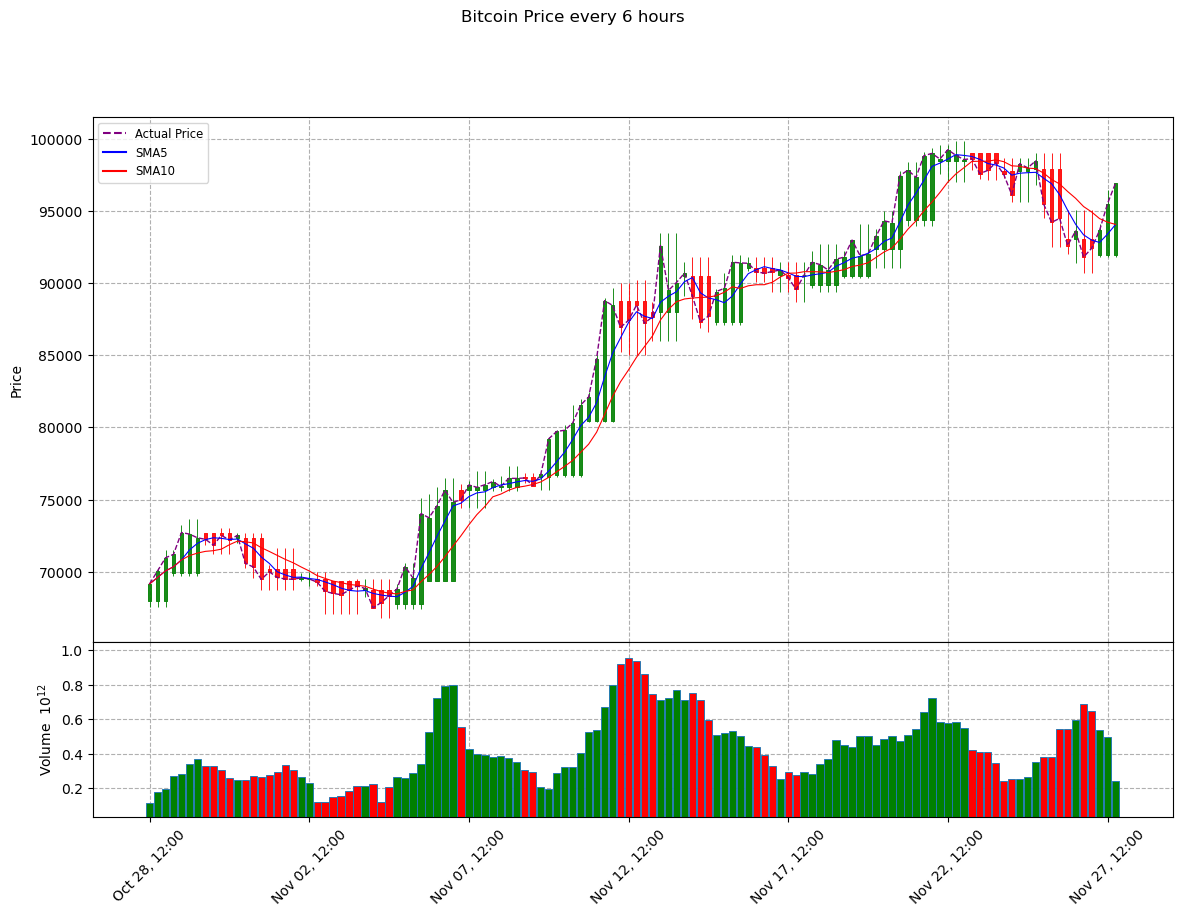

In [101]:
# Resample to 6-hour intervals
daily_data = btc_data.resample('6H').agg({
    'open': 'first',
    'price': 'last',
    'dayHigh': 'max',
    'dayLow': 'min',
    'volume': 'sum'
})

# Clean and rename columns for mplfinance
daily_data = daily_data.fillna(method='ffill').dropna()
daily_data = daily_data.rename(columns={
    'price': 'Close',
    'dayHigh': 'High',
    'dayLow': 'Low',
    'open': 'Open',
    'volume': 'Volume'
})

# Add moving averages
daily_data['SMA5'] = daily_data['Close'].rolling(window=5, min_periods=1).mean()
daily_data['SMA10'] = daily_data['Close'].rolling(window=10, min_periods=1).mean()


def plot_candlestick(daily_data):
    """Create candlestick chart with indicators."""
    # Define style
    mc = mpf.make_marketcolors(
        up='green', down='red', edge='inherit',
        volume='in', wick={'up': 'green', 'down': 'red'}
    )
    style = mpf.make_mpf_style(
        marketcolors=mc, gridstyle='--', y_on_right=False
    )
    
    # Define additional plots
    apds = [
        mpf.make_addplot(daily_data['Close'], color='purple', width=1.0, 
                        linestyle='--', ylabel='Actual Price'),
        mpf.make_addplot(daily_data['SMA5'], color='blue', width=0.8, 
                        ylabel='SMA5'),
        mpf.make_addplot(daily_data['SMA10'], color='red', width=0.8, 
                        ylabel='SMA10')
    ]
    
    # Create plot
    fig, axes = mpf.plot(
        daily_data,
        type='candle',
        style=style,
        volume=True,
        addplot=apds,
        title='Bitcoin Price every 6 hours',
        panel_ratios=(3, 1),
        figsize=(15, 10),
        returnfig=True
    )
    
    # Add legend
    handles = [
        plt.Line2D([], [], color='purple', linestyle='--', label='Actual Price'),
        plt.Line2D([], [], color='blue', label='SMA5'),
        plt.Line2D([], [], color='red', label='SMA10')
    ]
    axes[0].legend(handles=handles, loc='best', fontsize='small')
    
    return fig, axes
# Create candlestick chart
fig_candle, _ = plot_candlestick(daily_data)
plt.show()

### Return outlier Analysis

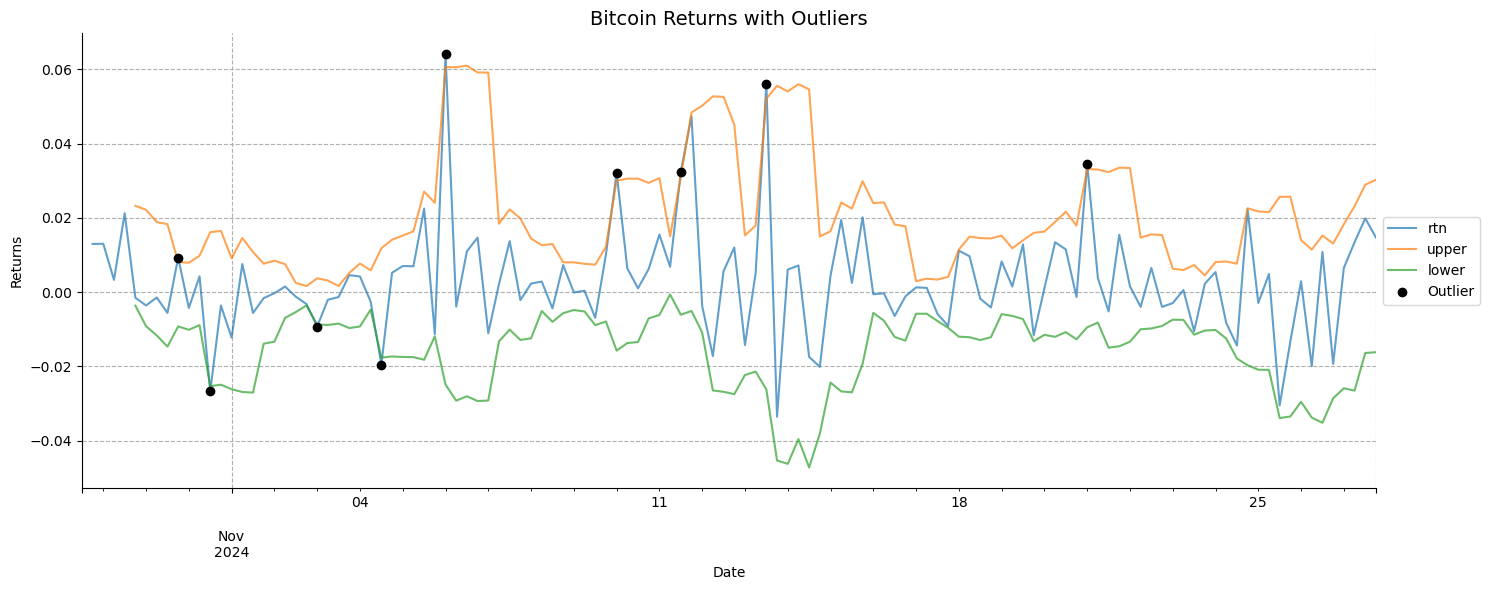

In [102]:
def analyze_returns(daily_data):
    """Analyze price returns and detect outliers."""
    # Calculate returns
    daily_data['rtn'] = daily_data['Close'].pct_change()
    
    # Calculate rolling statistics
    df_rolling = daily_data[['rtn']].rolling(window=5).agg(["mean", "std"])
    df_rolling.columns = ["mean", "std"]
    df_rolling = df_rolling.dropna()
    
    # Calculate bounds
    N_SIGMAS = 1.5
    df_rolling["upper"] = df_rolling["mean"] + N_SIGMAS * df_rolling["std"]
    df_rolling["lower"] = df_rolling["mean"] - N_SIGMAS * df_rolling["std"]
    
    # Identify outliers
    analysis_df = daily_data[['rtn']].join(df_rolling, how="left")
    analysis_df["outlier"] = (
        (analysis_df["rtn"] > analysis_df["upper"]) | 
        (analysis_df["rtn"] < analysis_df["lower"])
    )
    
    return analysis_df

def plot_returns(analysis_df):
    """Plot returns analysis with outliers."""
    fig, ax = plt.subplots(figsize=(15, 6))  # Matched size with technical analysis plots
    
    # Plot returns and bounds
    analysis_df[["rtn", "upper", "lower"]].plot(ax=ax, alpha=0.7)
    
    # Highlight outliers
    ax.scatter(
        analysis_df.loc[analysis_df["outlier"]].index,
        analysis_df.loc[analysis_df["outlier"], "rtn"],
        color="black", label="Outlier", zorder=5
    )
    
    # Customize plot
    ax.set_title("Bitcoin Returns with Outliers", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Returns")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    sns.despine()
    plt.tight_layout()
    
    return fig, ax

# Analyze returns
returns_analysis = analyze_returns(daily_data)
fig_returns, _ = plot_returns(returns_analysis)
plt.show()

### Technical Indicator Analysis

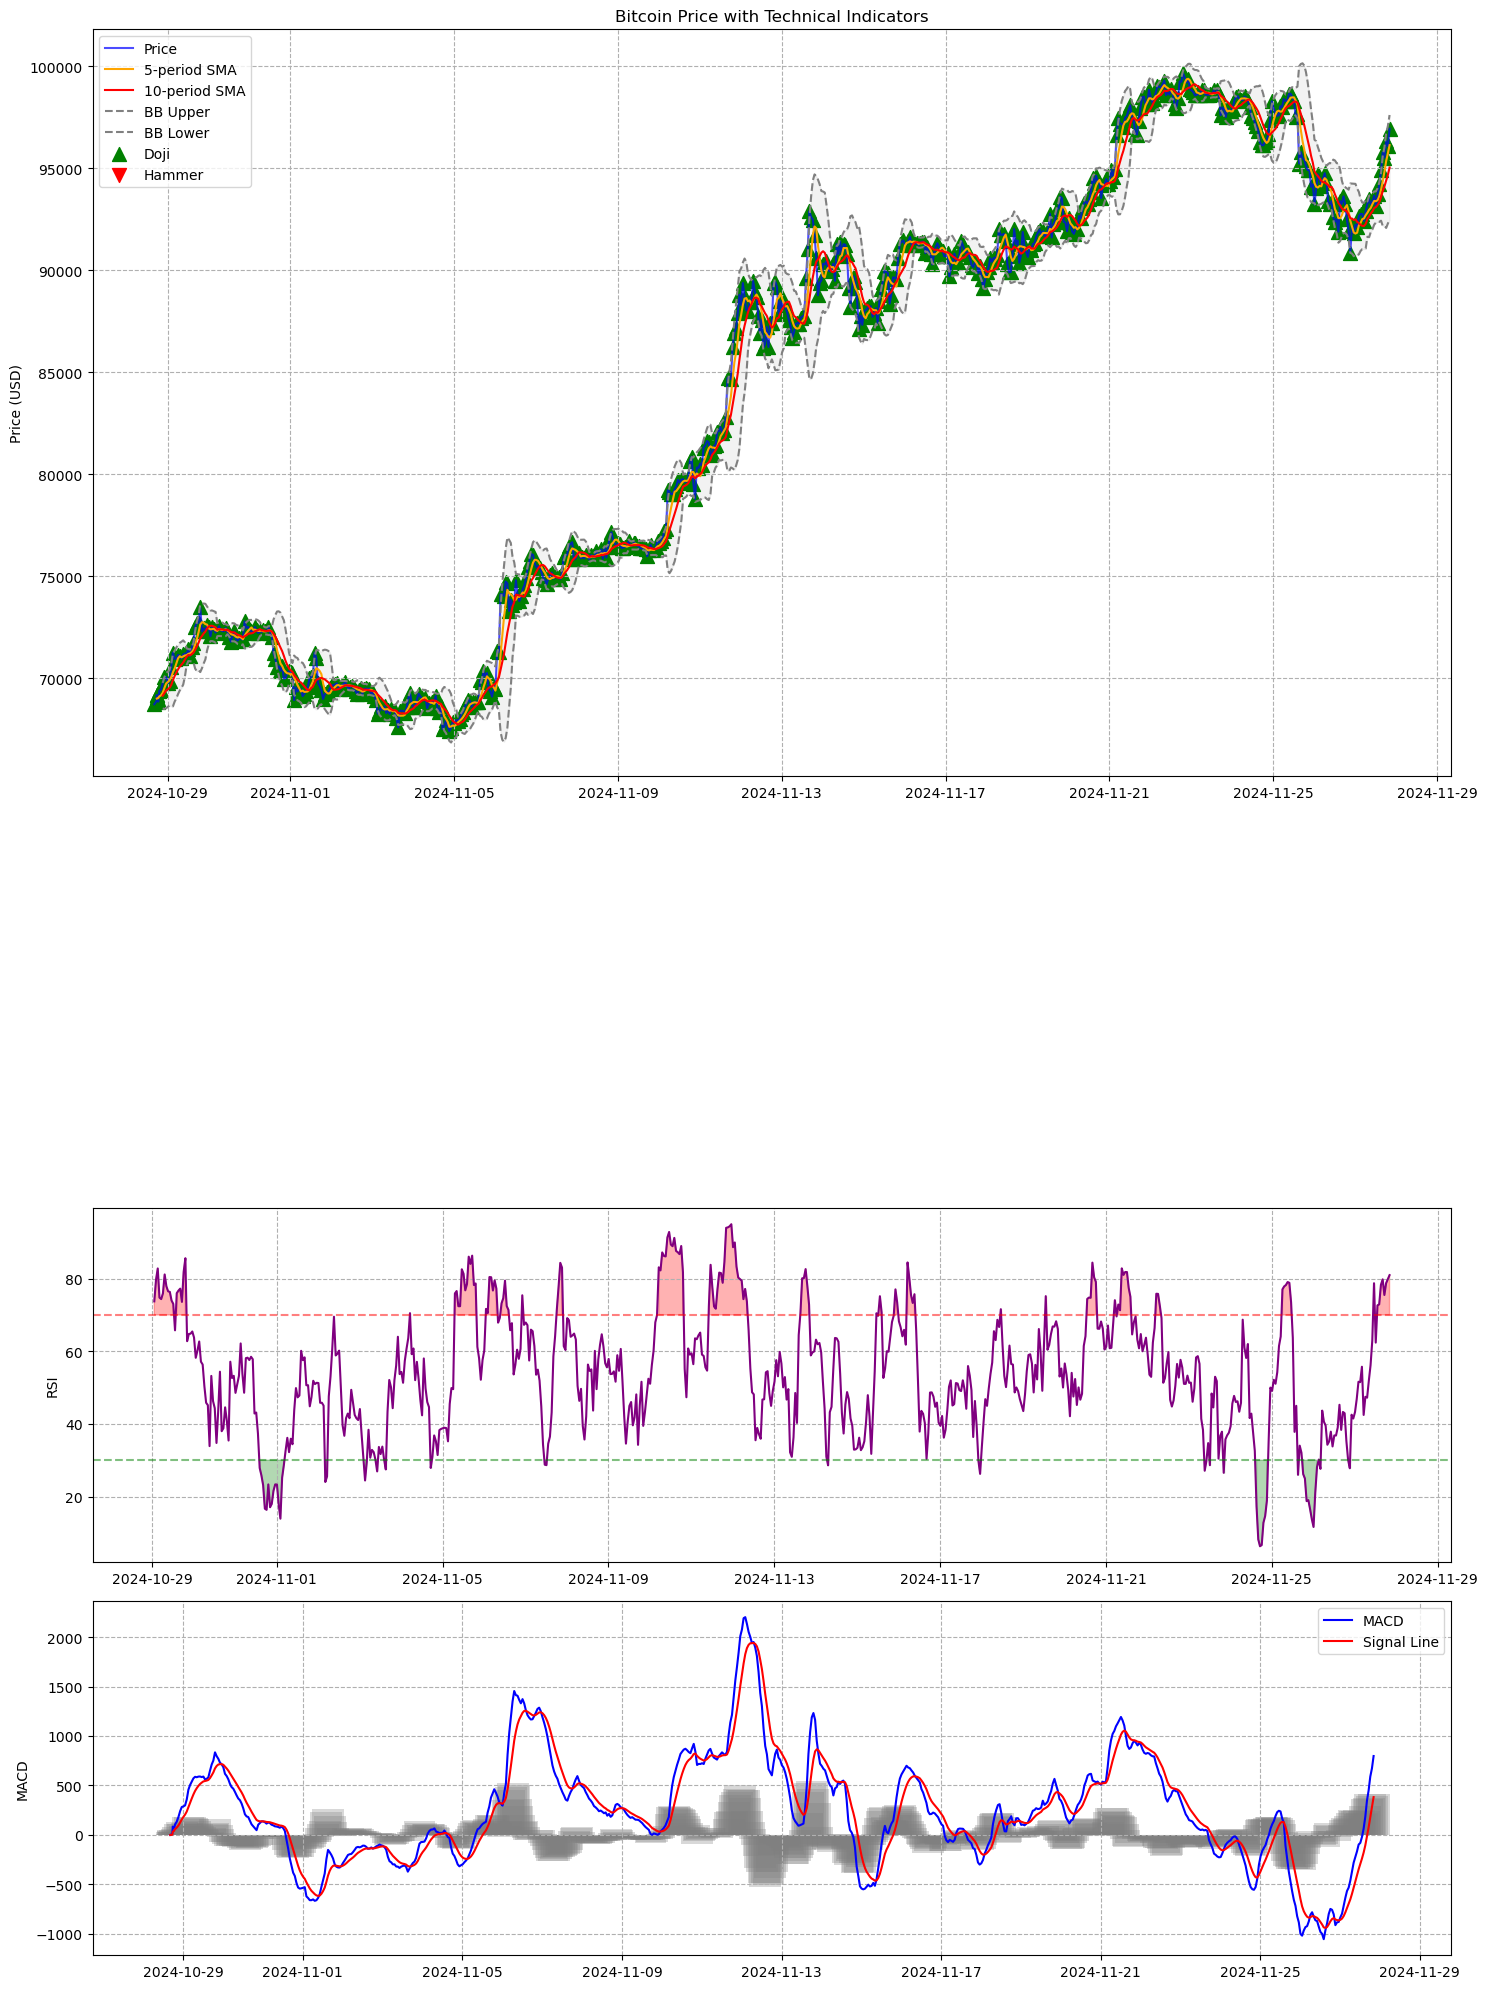

In [103]:
def calculate_technical_indicators(df):
    """Calculate technical indicators for the dataset."""
    # Moving averages
    df['SMA_5'] = df['price'].rolling(window=5).mean()
    df['SMA_10'] = df['price'].rolling(window=10).mean()
    
    # Bollinger Bands
    df['BB_middle'] = df['price'].rolling(window=10).mean()
    df['BB_upper'] = df['BB_middle'] + 2 * df['price'].rolling(window=10).std()
    df['BB_lower'] = df['BB_middle'] - 2 * df['price'].rolling(window=10).std()
    
    # RSI
    delta = df['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['price'].ewm(span=12, adjust=False).mean()
    exp2 = df['price'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    
    # Candlestick patterns
    df['Doji'] = detect_doji(df)
    df['Hammer'] = detect_hammer(df)
    
    return df

def detect_doji(df, threshold=0.1):
    """Detect Doji candlestick patterns."""
    body = abs(df['close'] - df['open'])
    wick = df['dayHigh'] - df['dayLow']
    return body <= (wick * threshold)

def detect_hammer(df):
    """Detect Hammer candlestick patterns."""
    body = abs(df['close'] - df['open'])
    upper_wick = df['dayHigh'] - df[['open', 'close']].max(axis=1)
    lower_wick = df[['open', 'close']].min(axis=1) - df['dayLow']
    return (lower_wick > (2 * body)) & (upper_wick < body)

def plot_technical_analysis(df):
    """Create comprehensive technical analysis plot."""
    fig = plt.figure(figsize=(15, 20))
    
    # Price and indicators plot
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=2)
    ax1.plot(df.index, df['price'], label='Price', color='blue', alpha=0.7)
    ax1.plot(df.index, df['SMA_5'], label='5-period SMA', color='orange')
    ax1.plot(df.index, df['SMA_10'], label='10-period SMA', color='red')
    ax1.plot(df.index, df['BB_upper'], label='BB Upper', color='gray', linestyle='--')
    ax1.plot(df.index, df['BB_lower'], label='BB Lower', color='gray', linestyle='--')
    ax1.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.1, color='gray')
    
    # Plot patterns
    doji_points = df[df['Doji']].index
    hammer_points = df[df['Hammer']].index
    ax1.scatter(doji_points, df.loc[doji_points, 'price'], 
                marker='^', color='green', label='Doji', s=100)
    ax1.scatter(hammer_points, df.loc[hammer_points, 'price'], 
                marker='v', color='red', label='Hammer', s=100)
    
    ax1.set_title('Bitcoin Price with Technical Indicators')
    ax1.set_ylabel('Price (USD)')
    ax1.legend()
    ax1.grid(True)
    
    # RSI plot
    ax3 = plt.subplot2grid((5, 1), (3, 0))
    ax3.plot(df.index, df['RSI'], color='purple')
    ax3.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax3.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax3.fill_between(df.index, 70, df['RSI'], 
                     where=(df['RSI'] >= 70), color='r', alpha=0.3)
    ax3.fill_between(df.index, 30, df['RSI'], 
                     where=(df['RSI'] <= 30), color='g', alpha=0.3)
    ax3.set_ylabel('RSI')
    ax3.grid(True)
    
    # MACD plot
    ax4 = plt.subplot2grid((5, 1), (4, 0))
    ax4.plot(df.index, df['MACD'], label='MACD', color='blue')
    ax4.plot(df.index, df['Signal_Line'], label='Signal Line', color='red')
    ax4.bar(df.index, df['MACD_Histogram'], color='gray', alpha=0.3)
    ax4.set_ylabel('MACD')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    return fig

# Calculate indicators and create technical analysis plot
df_with_indicators = calculate_technical_indicators(btc_data)
fig_technical = plot_technical_analysis(df_with_indicators)
plt.show()

## II Twitter Sentimental Analysis

In [104]:
tw_data = pd.read_csv('twitter_data.csv',index_col=0)
tw_data.head(5)

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time
_id,,,,,,,,,,,,,
671fe1125a22311369600909,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090a,BTC,bitcoin,1850228656704049285,Ashcryptoreal,88.0,9210.0,Sat Oct 26 17:31:02 +0000 2024,"If Bitcoin breaks $72,000 by the end \nof Octo...",en,21.0,952.0,1278.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090b,BTC,bitcoin,1849812562323325395,Vivek4real_,23.0,4219.0,Fri Oct 25 13:57:37 +0000 2024,"Like, If you think Microsoft should convert $7...",en,14.0,163.0,339.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090c,BTC,bitcoin,1849150584693076274,MarwanNawaz,6.0,458.0,Wed Oct 23 18:07:09 +0000 2024,"Michael Saylor would ""volunteer"" his Bitcoin t...",en,3.0,9.0,74.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090d,BTC,bitcoin,1848948161806798989,naiivememe,1779.0,10437.0,Wed Oct 23 04:42:48 +0000 2024,Me leaving my 9-5 job when Bitcoin hits 250K\n...,en,104.0,272.0,889.0,2024-10-28 19:08:02.786000


### Flair Sentiment Analysis
- Test out Flair using selected twitter sample.
- Reference: [Flair](https://github.com/flairNLP/flair)

In [105]:
from flair.data import Sentence
from flair.nn import Classifier

sample = tw_data.iloc[0]["text"]
print("Sample: ", sample)
sentence = Sentence(sample)

tagger = Classifier.load('sentiment')
tagger.predict(sentence)

print("Sentiment Value: ", sentence.labels[0].value)
print("Sentiment Confidence: ", sentence.labels[0].score)

Sample:  Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ
Sentiment Value:  POSITIVE
Sentiment Confidence:  0.9328526854515076


## VADER Sentiment Analysis
- Test out VADER using selected Twitter sample.
- Reference: [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment)

In [106]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sample = tw_data.iloc[0]["text"]
print("Sample: ", sample)

analyzer = SentimentIntensityAnalyzer()

vs = analyzer.polarity_scores(sample)
print("{:-<65} {}".format(sample, str(vs)))

Sample:  Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ
Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.5106}


### Data Preprocessing
- Extract link values from the **text** column with regex.
- Remove all "\n" from the **text** column.
- Assert if there is any missing value for the **text** column.
- Assert if there is any empty string for the **text** column.

In [107]:
import re
import util.text as t

In [108]:
# Assert if there is any missing values for the **text** column
# assert tw_data.isnull().sum()['text'] == 0

In [109]:
# If there is missing values, drop these missing values
tw_data = tw_data.dropna()

In [110]:
# Extract link values from the **text** column with regex.
tw_data['text'] = tw_data['text'].apply(
  lambda x: re.sub(r'https?://\S+', '', x).strip()
  )  
# Remove all "\n" from the **text** column.
tw_data['text'] = tw_data['text'].replace('\n', '', regex=True)

tw_data.iloc[1]['text']

'If Bitcoin breaks $72,000 by the end of October, I will give $2,000 BTC to 20 people who like this post.'

In [111]:
# Assert if there is any empty strings for the **text** column
# assert len(tw_data.index[tw_data['text'] == ''].tolist()) == 0

In [112]:
# Check empty string for the **text** colum
print("Number of empty strings: ", len(tw_data.index[tw_data['text'] == ''].tolist()))
tw_data.index[tw_data['text'] == ''].tolist()[:5]

Number of empty strings:  39


['6725c23c2ecab7f9c39b03c1',
 '6725fa7e69400ce2a905b5de',
 '6726952c7222003579d6c677',
 '6726a33c966067f276961a06',
 '6726bf5f062b2dc3b39b4ca1']

In [113]:
# Apply Flair sentiment anaylysis to the twitter dataset.
tw_data[['fl_sentiment', 'fl_confidence']] = tw_data['text'].apply(
  lambda x: pd.Series(t.flair_sentiment(x))
  )

tw_data['fl_sentiment'].head(1)
tw_data['fl_confidence'].head(1)

String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be

String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be

String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


_id
671fe1125a22311369600909    0.837528
Name: fl_confidence, dtype: float64

In [114]:
# Apply VADER sentiment anaylysis to the twitter dataset.
tw_data[['vd_negative', 'vd_neutral', 'vd_positive', 'vd_compound']] = tw_data['text'].apply(
  lambda x: pd.Series(t.vader_sentiment(x))
  )

tw_data.head(1)

String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be

String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time,fl_sentiment,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
_id,,,,,,,,,,,,,,,,,,,
671fe1125a22311369600909,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786000,POSITIVE,0.837528,0.0,0.769,0.231,0.5106


In [115]:
# Convert current cleaned data to csv
tw_data.to_csv('updated_twitter_data.csv', index=False)

## Visualize Preprocessed Data

In [116]:
tw_data = pd.read_csv('updated_twitter_data.csv')
tw_data.describe()

,tweet_id,bookmarks,favorites,quotes,replies,retweets,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
count,1.207800e+04,12078.000000,12078.000000,12078.000000,12078.000000,12078.000000,12039.000000,12039.000000,12039.000000,12039.000000,12039.000000
mean,1.855260e+18,320.077745,6307.339129,67.245984,594.567395,1260.782083,0.948589,0.026164,0.880151,0.093680,0.192342
std,5.680791e+15,885.494704,11757.474182,223.043356,1895.199431,2832.791556,0.100787,0.077826,0.141223,0.127636,0.386998
min,1.722846e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.504756,0.000000,0.218000,0.000000,-0.945100
25%,1.852763e+18,19.000000,825.000000,5.000000,49.000000,136.000000,0.956594,0.000000,0.775000,0.000000,0.000000
50%,1.855918e+18,80.000000,2701.000000,18.000000,169.000000,426.000000,0.997250,0.000000,0.917000,0.000000,0.000000
75%,1.858449e+18,241.000000,7029.500000,49.000000,469.000000,1193.750000,0.999667,0.000000,1.000000,0.187000,0.492600
max,1.861854e+18,17293.000000,208292.000000,3902.000000,50094.000000,43987.000000,0.999997,0.705000,1.000000,0.782000,0.995400


### Visualize Flair Sentiment Movements

In [117]:
# Preprocess fl_confidence value by fl_sentiment column.
tw_data['fl_confidence'] = np.where(tw_data['fl_sentiment'] == 'NEGATIVE', 
                                 -tw_data['fl_confidence'], 
                                 tw_data['fl_confidence'])
tw_data.head(3)

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time,fl_sentiment,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
0,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786000,POSITIVE,0.837528,0.0,0.769,0.231,0.5106
1,BTC,bitcoin,1850228656704049285,Ashcryptoreal,88.0,9210.0,Sat Oct 26 17:31:02 +0000 2024,"If Bitcoin breaks $72,000 by the end of Octobe...",en,21.0,952.0,1278.0,2024-10-28 19:08:02.786000,NEGATIVE,-0.999922,0.0,0.889,0.111,0.3612
2,BTC,bitcoin,1849812562323325395,Vivek4real_,23.0,4219.0,Fri Oct 25 13:57:37 +0000 2024,"Like, If you think Microsoft should convert $7...",en,14.0,163.0,339.0,2024-10-28 19:08:02.786000,NEGATIVE,-0.999045,0.0,0.839,0.161,0.3612


### 1. Visualize Mean and Median Values
- Calculate the mean and median of **confidence** column grouped by each hour.
- Calculate the mean and median of **confidence** column grouped by day.

In [118]:
tw_data['time'] = pd.to_datetime(tw_data['time'])

In [119]:
tw_data = tw_data.sort_values(by='time')

# Hourly mean
f_hr_mean = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].mean().reset_index()

f_hr_mean.head()

,time,fl_confidence
0,2024-10-28 19:00:00,-0.659364
1,2024-10-28 20:00:00,-0.856142
2,2024-10-28 21:00:00,-0.547036
3,2024-10-28 22:00:00,-0.756660
4,2024-10-28 23:00:00,-0.620880


In [120]:
# Hourly median
f_hr_med = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].median().reset_index()

f_hr_med.head()

,time,fl_confidence
0,2024-10-28 19:00:00,-0.962878
1,2024-10-28 20:00:00,-0.992461
2,2024-10-28 21:00:00,-0.991899
3,2024-10-28 22:00:00,-0.999045
4,2024-10-28 23:00:00,-0.966333


In [121]:
# Hourly standard deviation
f_hr_std = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].std().reset_index()

f_hr_std.head()

,time,fl_confidence
0,2024-10-28 19:00:00,0.691188
1,2024-10-28 20:00:00,0.479230
2,2024-10-28 21:00:00,0.801825
3,2024-10-28 22:00:00,0.631571
4,2024-10-28 23:00:00,0.749526


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


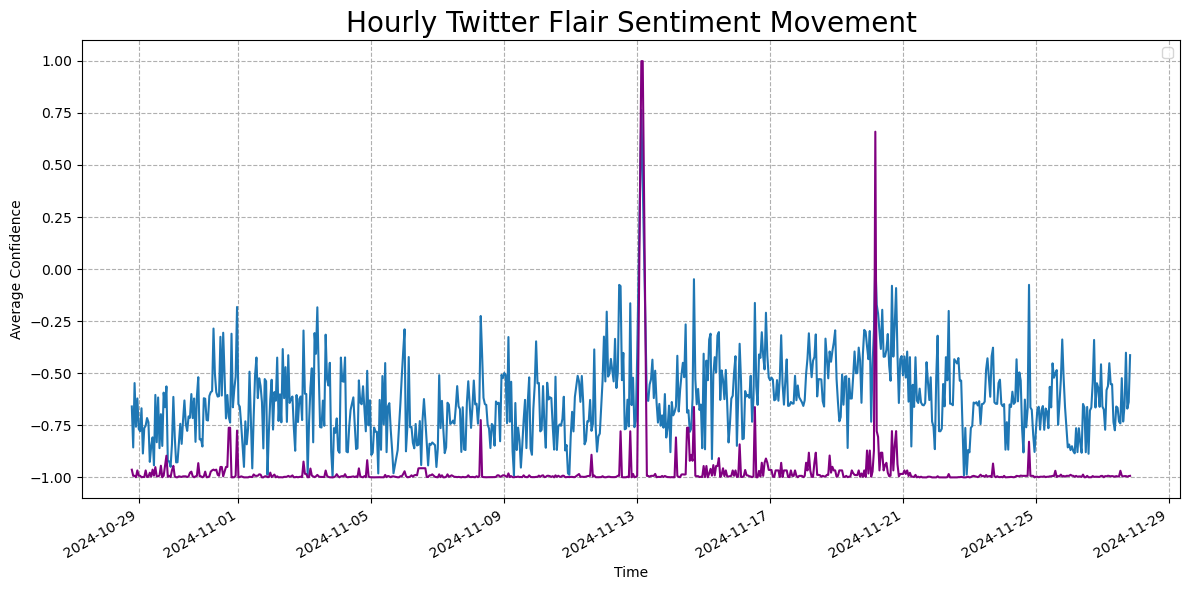

In [122]:
plt.figure(figsize=(12, 6))

plt.plot(f_hr_mean['time'], f_hr_mean['fl_confidence'])
plt.plot(f_hr_med['time'], f_hr_med['fl_confidence'], color='purple')

plt.title('Hourly Twitter Flair Sentiment Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()


In [123]:
# Daily mean
f_day_mean = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )['fl_confidence'].mean().reset_index()

f_day_mean.head()

,time,fl_confidence
0,2024-10-28,-0.683241
1,2024-10-29,-0.777407
2,2024-10-30,-0.742708
3,2024-10-31,-0.552631
4,2024-11-01,-0.686260


In [124]:
# Daily median
f_day_med = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )['fl_confidence'].median().reset_index()

f_day_med.head()

,time,fl_confidence
0,2024-10-28,-0.992180
1,2024-10-29,-0.994748
2,2024-10-30,-0.994748
3,2024-10-31,-0.965998
4,2024-11-01,-0.998059


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


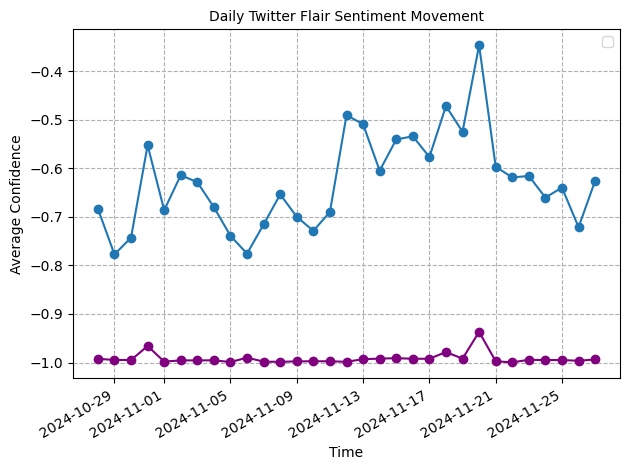

In [125]:
plt.figure()

plt.plot(f_day_mean['time'], f_day_mean['fl_confidence'], marker='o')
plt.plot(f_day_med['time'], f_day_med['fl_confidence'], color='purple', marker='o')

plt.title('Daily Twitter Flair Sentiment Movement', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

### 2. Visualize Sentiment Values
- For every hour, retrieve the number of "NEGATIVE" and "POSITIVE" from the **sentiment** column.
- Drop any empty data from **sentiment** column.

In [126]:
# For every hour, retrieve the number of "NEGATIVE" and "POSITIVE" from the **sentiment** column.
hr_pos_neg = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_sentiment'].value_counts().unstack().reset_index()

hr_pos_neg.head()

fl_sentiment,time,NEGATIVE,POSITIVE
0,2024-10-28 19:00:00,28.0,6.0
1,2024-10-28 20:00:00,16.0,1.0
2,2024-10-28 21:00:00,13.0,4.0
3,2024-10-28 22:00:00,15.0,2.0
4,2024-10-28 23:00:00,14.0,3.0


In [127]:
# Check if there is any empty data
hr_pos_neg.isnull().sum()

fl_sentiment
time         0
NEGATIVE     0
POSITIVE    24
dtype: int64

In [128]:
# Drop any empty data
hr_pos_neg = hr_pos_neg.dropna()[1:]

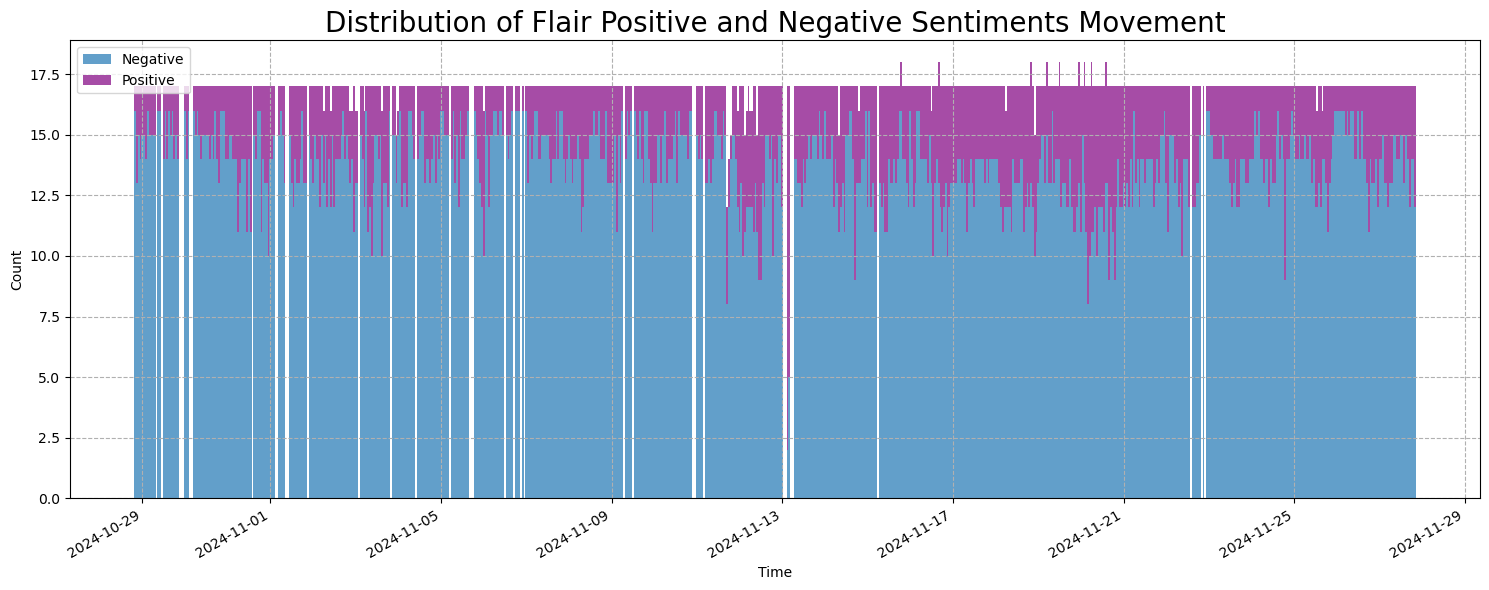

In [129]:
plt.figure(figsize=(15, 6))

plt.bar(hr_pos_neg['time'], hr_pos_neg['NEGATIVE'], width=1/24,
        alpha=0.7, label='Negative')

plt.bar(hr_pos_neg['time'], hr_pos_neg['POSITIVE'], width=1/24,
        bottom=hr_pos_neg['NEGATIVE'], color='purple', alpha=0.7, label='Positive')

plt.title('Distribution of Flair Positive and Negative Sentiments Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### Visualize VADER Sentiment Movement
- Calculate the mean and median of **confidence** column grouped by each hour.
- Calculate the mean and median of **confidence** column grouped by day.

In [130]:
# Hourly mean
v_hr_mean = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].mean().reset_index()

v_hr_mean.head()

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28 19:00:00,0.067324,0.039471,0.893147,0.090591
1,2024-10-28 20:00:00,0.055529,0.025824,0.918588,0.071700
2,2024-10-28 21:00:00,0.115412,0.000000,0.884588,0.287594
3,2024-10-28 22:00:00,0.070941,0.093176,0.835882,0.001594
4,2024-10-28 23:00:00,0.130353,0.000000,0.869647,0.282982


In [131]:
# Hourly median
v_hr_med = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].median().reset_index()

v_hr_med.head()

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28 19:00:00,0.000,0.0,0.903,0.0000
1,2024-10-28 20:00:00,0.000,0.0,1.000,0.0000
2,2024-10-28 21:00:00,0.123,0.0,0.877,0.3182
3,2024-10-28 22:00:00,0.000,0.0,0.839,0.0000
4,2024-10-28 23:00:00,0.123,0.0,0.877,0.3182


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


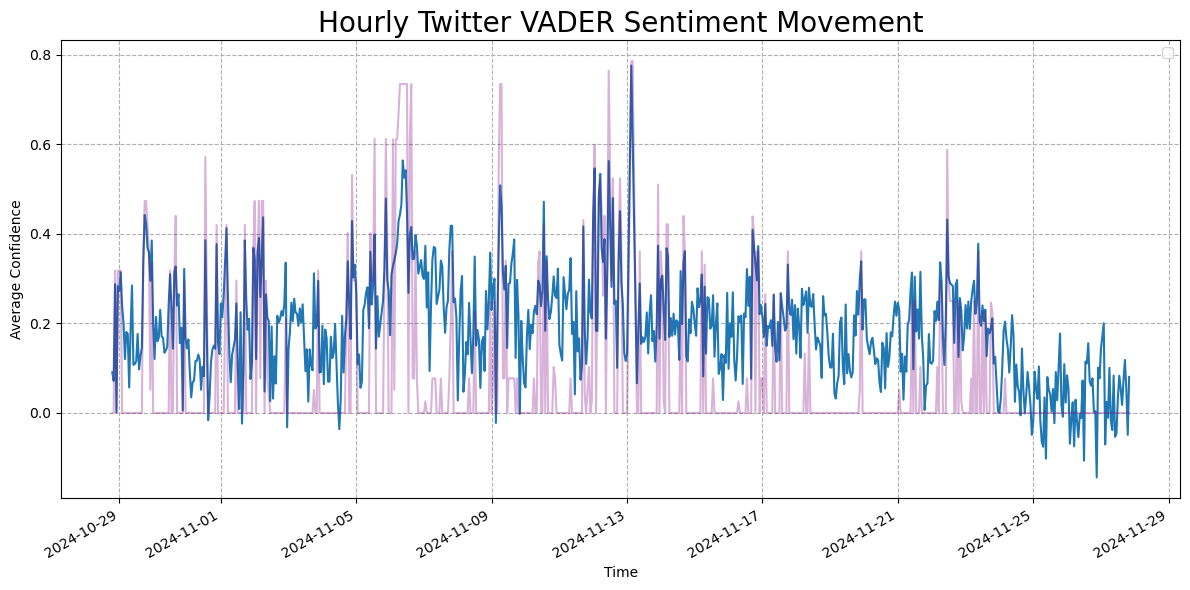

In [132]:
plt.figure(figsize=(12, 6))

plt.plot(v_hr_mean['time'], v_hr_mean['vd_compound'])
plt.plot(v_hr_med['time'], v_hr_med['vd_compound'], color='purple', alpha=0.3)

plt.title('Hourly Twitter VADER Sentiment Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [133]:
# Daily mean
v_day_mean = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].mean().reset_index()

v_day_mean.head()

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28,0.084480,0.032990,0.882500,0.137509
1,2024-10-29,0.087436,0.020728,0.891824,0.229950
2,2024-10-30,0.078708,0.015728,0.905576,0.199071
3,2024-10-31,0.066368,0.030445,0.903187,0.126812
4,2024-11-01,0.080500,0.029864,0.889636,0.188688


In [134]:
# Daily median
v_day_med = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].median().reset_index()

v_day_med.head()

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28,0.0,0.0,0.889,0.0
1,2024-10-29,0.0,0.0,0.889,0.0
2,2024-10-30,0.0,0.0,1.000,0.0
3,2024-10-31,0.0,0.0,1.000,0.0
4,2024-11-01,0.0,0.0,1.000,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


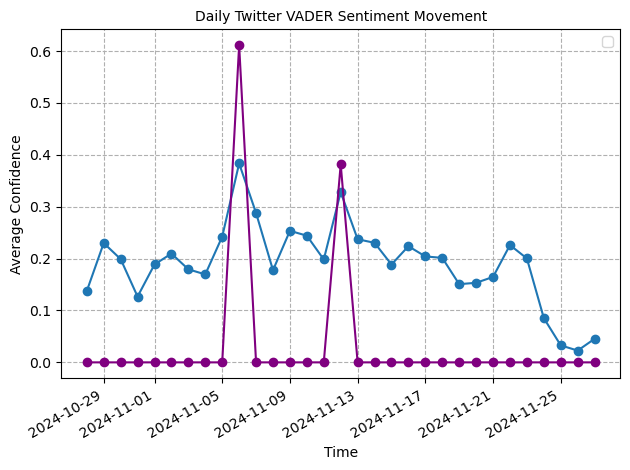

In [135]:
plt.figure()

plt.plot(v_day_mean['time'], v_day_mean['vd_compound'], marker='o')
plt.plot(v_day_med['time'], v_day_med['vd_compound'], color='purple',  marker='o')

plt.title('Daily Twitter VADER Sentiment Movement', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

### Visualize both Sentiment Movements

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


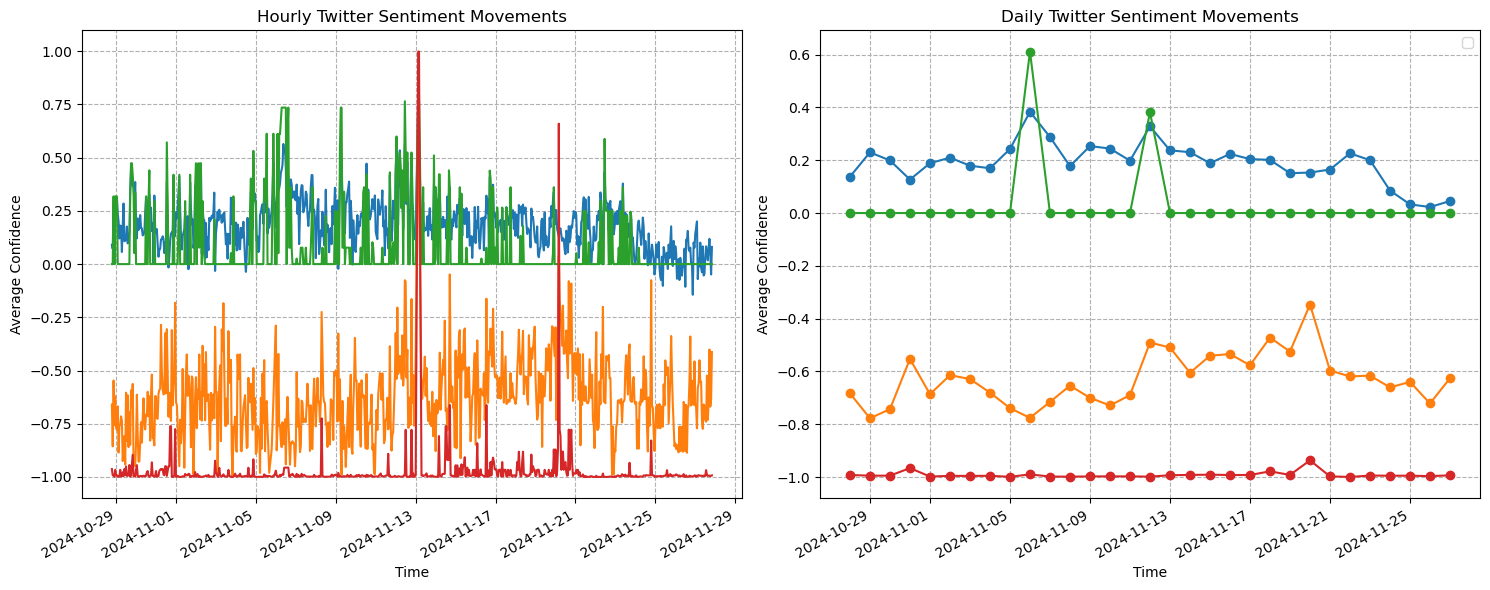

In [136]:
# Twitter sentiment movements through time
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(v_hr_mean['time'], v_hr_mean['vd_compound'])
ax[0].plot(f_hr_mean['time'], f_hr_mean['fl_confidence'])
ax[0].plot(v_hr_med['time'], v_hr_med['vd_compound'])
ax[0].plot(f_hr_med['time'], f_hr_med['fl_confidence'])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Average Confidence")
ax[0].set_title("Hourly Twitter Sentiment Movements")

ax[1].plot(v_day_mean['time'], v_day_mean['vd_compound'], marker='o')
ax[1].plot(f_day_mean['time'], f_day_mean['fl_confidence'], marker='o')
ax[1].plot(v_day_med['time'], v_day_med['vd_compound'], marker='o')
ax[1].plot(f_day_med['time'], f_day_med['fl_confidence'], marker='o')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Average Confidence")
ax[1].set_title("Daily Twitter Sentiment Movements")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

## Find Correlation between Bitcoin Price Movemnent VS. Twitter Sentiment

In [137]:
# Clean hourly BTC price data

hr_btc = btc_data
hr_btc['time'] = pd.to_datetime(hr_btc['time'])
hr_btc['time'] = hr_btc['time'].dt.floor('h')
  
hr_btc.head(5)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,SMA_10,BB_middle,BB_upper,BB_lower,RSI,MACD,Signal_Line,MACD_Histogram,Doji,Hammer
timestamp,,,,,,,,,,,,,,,,,,,,
2024-10-28 16:14:23,BTC,Bitcoin USD,68720.00,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,True,False
2024-10-28 17:29:02,BTC,Bitcoin USD,68862.88,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,11.397835,2.279567,9.118268,True,False
2024-10-28 17:33:29,BTC,Bitcoin USD,69086.55,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,38.040494,9.431752,28.608741,True,False
2024-10-28 17:43:23,BTC,Bitcoin USD,69172.61,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,65.346047,20.614611,44.731436,True,False
2024-10-28 17:44:59,BTC,Bitcoin USD,69151.61,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,68998.73,NaN,NaN,NaN,NaN,NaN,84.319388,33.355567,50.963822,True,False


In [142]:
import pandas as pd

# Load the hourly dataset
btc_data = pd.read_csv('hourly_btc_tw_data.csv')

# Convert 'time' to datetime
btc_data['time'] = pd.to_datetime(btc_data['time'])

# Resample to daily intervals and calculate required metrics
day_btc = btc_data.resample('D', on='time').agg({
    'price': ['first', 'last', 'mean'],  # Open, Close, and Average Price
    'volume': 'sum',                     # Total Volume
    'dayHigh': 'max',                    # Daily High Price
    'dayLow': 'min',                     # Daily Low Price
    'SMA_5': 'mean',                     # Average SMA_5
    'SMA_10': 'mean',                    # Average SMA_10
    'RSI': 'mean',                       # Average RSI
    'MACD': 'last',                      # Last MACD Value of the Day
    'Signal_Line': 'last',               # Last Signal Line of the Day
    'MACD_Histogram': 'last'             # Last MACD Histogram of the Day
}).reset_index()

# Fix for multi-level columns
day_btc.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in day_btc.columns]

# Reformat column names
day_btc = day_btc.rename(columns={
    'time_': 'time',
    'price_first': 'open',
    'price_last': 'close',
    'price_mean': 'price',
    'volume_sum': 'volume',
    'dayHigh_max': 'dayHigh',
    'dayLow_min': 'dayLow',
    'SMA_5_mean': 'SMA_5',
    'SMA_10_mean': 'SMA_10',
    'RSI_mean': 'RSI',
    'MACD_last': 'MACD',
    'Signal_Line_last': 'Signal_Line',
    'MACD_Histogram_last': 'MACD_Histogram'
})

# Display the first few rows of the resampled daily data
print("\nFirst few rows:")
print(day_btc.head())

# Check the data types and missing values
print("\nDataset Info:")
print(day_btc.info())

print("\nMissing Values:")
print(day_btc.isnull().sum())

# Save the daily data to a CSV file
day_btc.to_csv('day_btc_data.csv', index=False)


First few rows:
        time      open     close         price        volume   dayHigh  \
0 2024-10-28  69376.60  70051.00  69732.718000  1.301950e+11  70288.00   
1 2024-10-29  69752.42  72607.98  71537.300417  1.092847e+12  73624.98   
2 2024-10-30  72508.29  72515.00  72240.830417  1.336778e+12  73624.98   
3 2024-10-31  72364.69  70327.64  71554.782609  9.876689e+11  73060.00   
4 2024-11-01  70279.98  69493.18  69687.498182  1.083267e+12  72684.02   

     dayLow         SMA_5        SMA_10        RSI        MACD  Signal_Line  \
0  67532.48  69356.463200  69265.223667        NaN  282.484373   156.474843   
1  67532.48  71326.418000  70980.873500  74.561607  713.869070   715.268277   
2  69705.76  72238.347000  72298.577625  48.791275  137.377439   137.749967   
3  69559.33  71717.061217  71901.077435  39.838041 -538.661435  -394.367773   
4  68720.00  69750.167727  69844.018682  42.428161 -312.413866  -316.362537   

   MACD_Histogram  
0      126.009530  
1       -1.399207  
2  

### Create Datasets on BTC Data and Sentiment Data

In [143]:
# Merge hourly btc_data with tw_data using sentiment mean values
df = pd.merge(hr_btc, v_hr_mean, on='time')
hr_btc_tw = pd.merge(df, f_hr_mean, on='time')

hr_btc_tw.head(5)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,MACD,Signal_Line,MACD_Histogram,Doji,Hammer,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,106.838570,59.863536,46.975034,True,False,0.067324,0.039471,0.893147,0.090591,-0.659364
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,135.800860,75.051001,60.749859,True,False,0.055529,0.025824,0.918588,0.071700,-0.856142
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,181.194439,96.279689,84.914751,True,False,0.115412,0.000000,0.884588,0.287594,-0.547036
3,BTC,Bitcoin USD,70056.00,70282.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 22:00:00,69515.700,...,239.743546,124.972460,114.771086,True,False,0.070941,0.093176,0.835882,0.001594,-0.756660
4,BTC,Bitcoin USD,70051.00,70288.0,67532.48,3.665087e+10,67939.54,67939.54,2024-10-28 23:00:00,69732.718,...,282.484373,156.474843,126.009530,True,False,0.130353,0.000000,0.869647,0.282982,-0.620880


In [144]:
# Merge daily btc_data with tw_data using sentiment mean values
df = pd.merge(day_btc, v_day_mean, on='time')
day_btc_tw = pd.merge(df, f_day_mean, on='time')

day_btc_tw.head(5)
# Save the daily data to a CSV file if needed
day_btc_tw.to_csv('day_btc_tw.csv', index=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


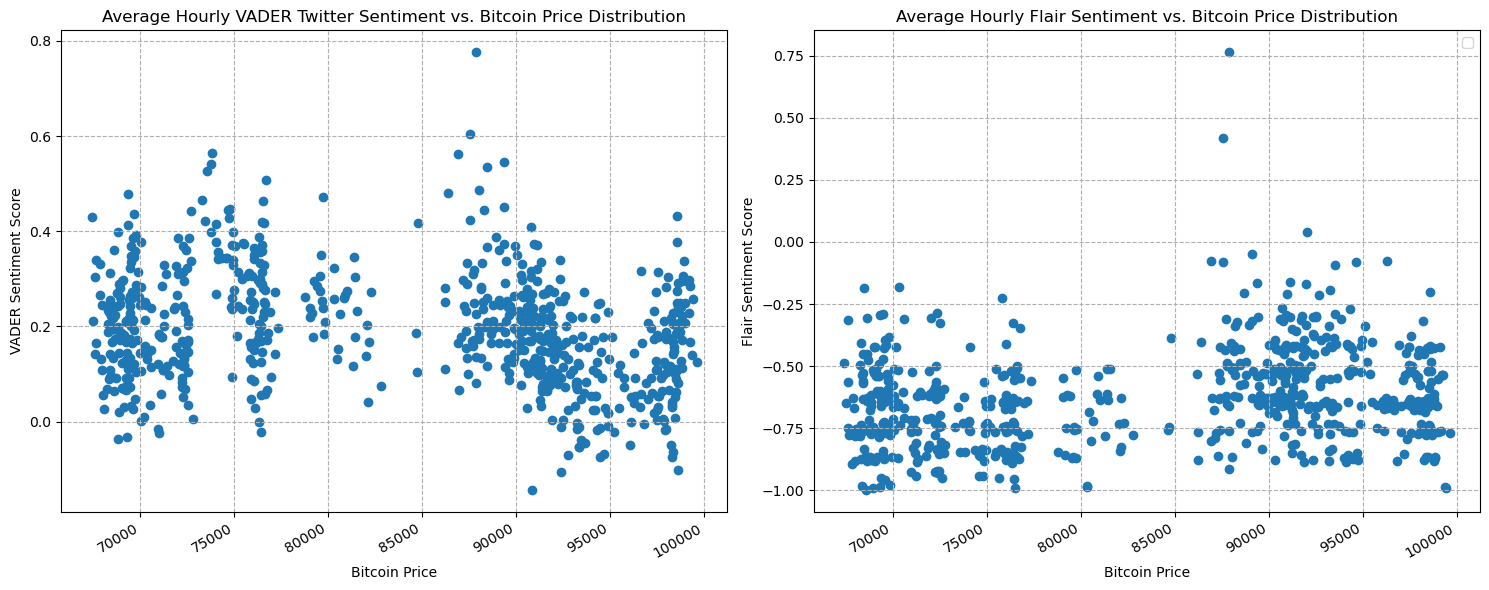

In [145]:
# Twitter sentiment vs. bitcoin price distribution 
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(hr_btc_tw['price'], hr_btc_tw['vd_compound'])
ax[0].set_xlabel("Bitcoin Price")
ax[0].set_ylabel("VADER Sentiment Score")
ax[0].set_title("Average Hourly VADER Twitter Sentiment vs. Bitcoin Price Distribution")

ax[1].scatter(hr_btc_tw['price'], hr_btc_tw['fl_confidence'] )
ax[1].set_xlabel("Bitcoin Price")
ax[1].set_ylabel("Flair Sentiment Score")
ax[1].set_title("Average Hourly Flair Sentiment vs. Bitcoin Price Distribution")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

## Bitcoin Price Delta VS. Mean Sentiment Delta
### Hourly Mean & Median Data

In [146]:
hr_btc_tw['price_delta'] = hr_btc_tw['price'].diff()
hr_btc_tw['fl_confidence_delta'] = hr_btc_tw['fl_confidence'].diff()
hr_btc_tw['vd_compound_delta'] = hr_btc_tw['vd_compound'].diff()

In [147]:
hr_btc_tw = hr_btc_tw.dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


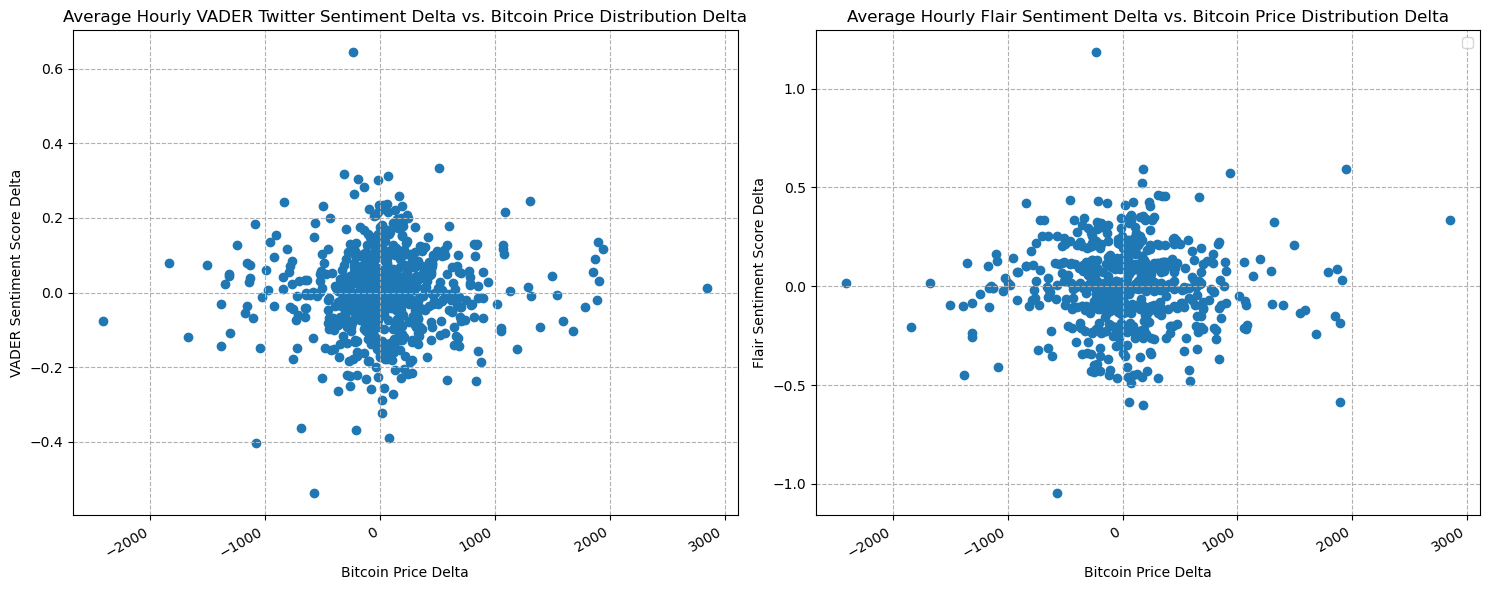

In [148]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(hr_btc_tw['price_delta'], hr_btc_tw['vd_compound_delta'])
ax[0].set_xlabel("Bitcoin Price Delta")
ax[0].set_ylabel("VADER Sentiment Score Delta")
ax[0].set_title("Average Hourly VADER Twitter Sentiment Delta vs. Bitcoin Price Distribution Delta")

ax[1].scatter(hr_btc_tw['price_delta'], hr_btc_tw['fl_confidence_delta'] )
ax[1].set_xlabel("Bitcoin Price Delta")
ax[1].set_ylabel("Flair Sentiment Score Delta")
ax[1].set_title("Average Hourly Flair Sentiment Delta vs. Bitcoin Price Distribution Delta")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


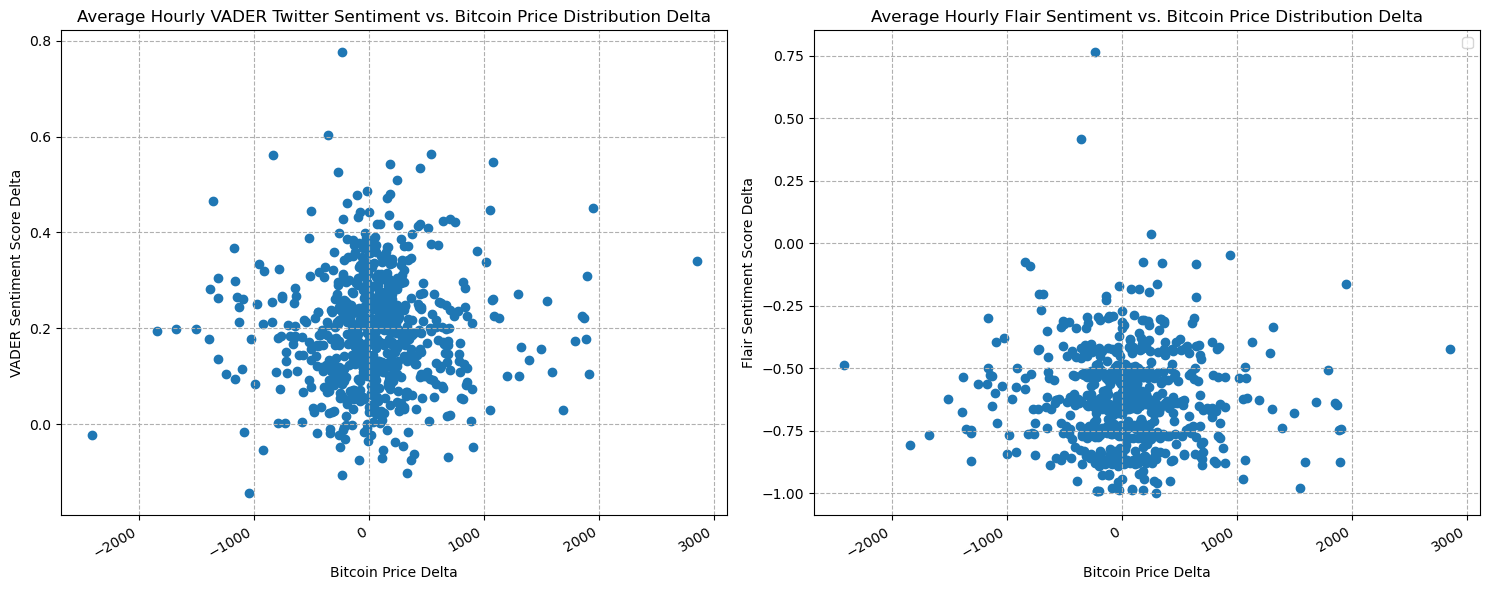

In [149]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(hr_btc_tw['price_delta'], hr_btc_tw['vd_compound'])
ax[0].set_xlabel("Bitcoin Price Delta")
ax[0].set_ylabel("VADER Sentiment Score Delta")
ax[0].set_title("Average Hourly VADER Twitter Sentiment vs. Bitcoin Price Distribution Delta")

ax[1].scatter(hr_btc_tw['price_delta'], hr_btc_tw['fl_confidence'] )
ax[1].set_xlabel("Bitcoin Price Delta")
ax[1].set_ylabel("Flair Sentiment Score Delta")
ax[1].set_title("Average Hourly Flair Sentiment vs. Bitcoin Price Distribution Delta")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [150]:
# Merge btc_data with tw_data using sentiment median values
df = pd.merge(hr_btc, v_hr_med, on='time')
hr_btc_tw = pd.merge(df, f_hr_med, on='time')

hr_btc_tw.head(5)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,MACD,Signal_Line,MACD_Histogram,Doji,Hammer,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,106.838570,59.863536,46.975034,True,False,0.000,0.0,0.903,0.0000,-0.962878
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,135.800860,75.051001,60.749859,True,False,0.000,0.0,1.000,0.0000,-0.992461
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,181.194439,96.279689,84.914751,True,False,0.123,0.0,0.877,0.3182,-0.991899
3,BTC,Bitcoin USD,70056.00,70282.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 22:00:00,69515.700,...,239.743546,124.972460,114.771086,True,False,0.000,0.0,0.839,0.0000,-0.999045
4,BTC,Bitcoin USD,70051.00,70288.0,67532.48,3.665087e+10,67939.54,67939.54,2024-10-28 23:00:00,69732.718,...,282.484373,156.474843,126.009530,True,False,0.123,0.0,0.877,0.3182,-0.966333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


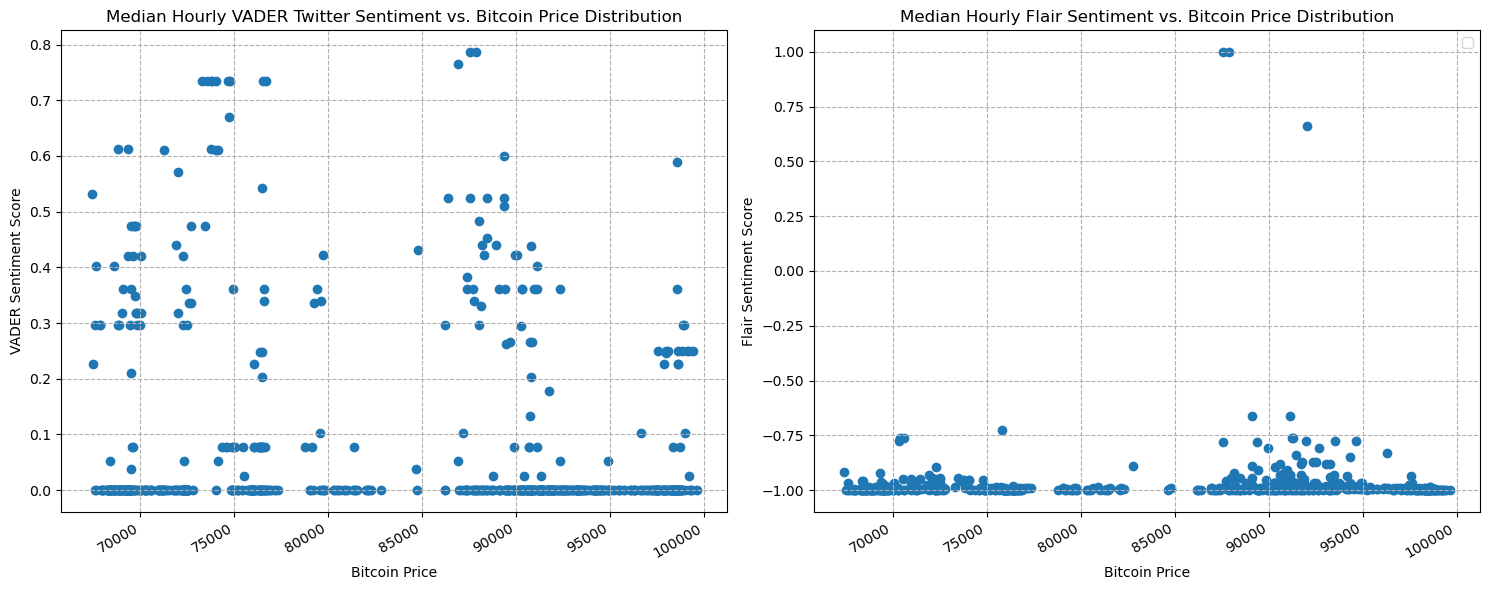

In [151]:
# Twitter sentiment vs. bitcoin price distribution 
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(hr_btc_tw['price'], hr_btc_tw['vd_compound'])
ax[0].set_xlabel("Bitcoin Price")
ax[0].set_ylabel("VADER Sentiment Score")
ax[0].set_title("Median Hourly VADER Twitter Sentiment vs. Bitcoin Price Distribution")

ax[1].scatter(hr_btc_tw['price'], hr_btc_tw['fl_confidence'] )
ax[1].set_xlabel("Bitcoin Price")
ax[1].set_ylabel("Flair Sentiment Score")
ax[1].set_title("Median Hourly Flair Sentiment vs. Bitcoin Price Distribution")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [152]:
hr_btc_tw['price_delta'] = hr_btc_tw['price'].diff()
hr_btc_tw['volume_delta'] = hr_btc_tw['volume'].diff()
hr_btc_tw['fl_confidence_delta'] = hr_btc_tw['fl_confidence'].diff()
hr_btc_tw['vd_compound_delta'] = hr_btc_tw['vd_compound'].diff()

In [153]:
hr_btc_tw = hr_btc_tw.dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


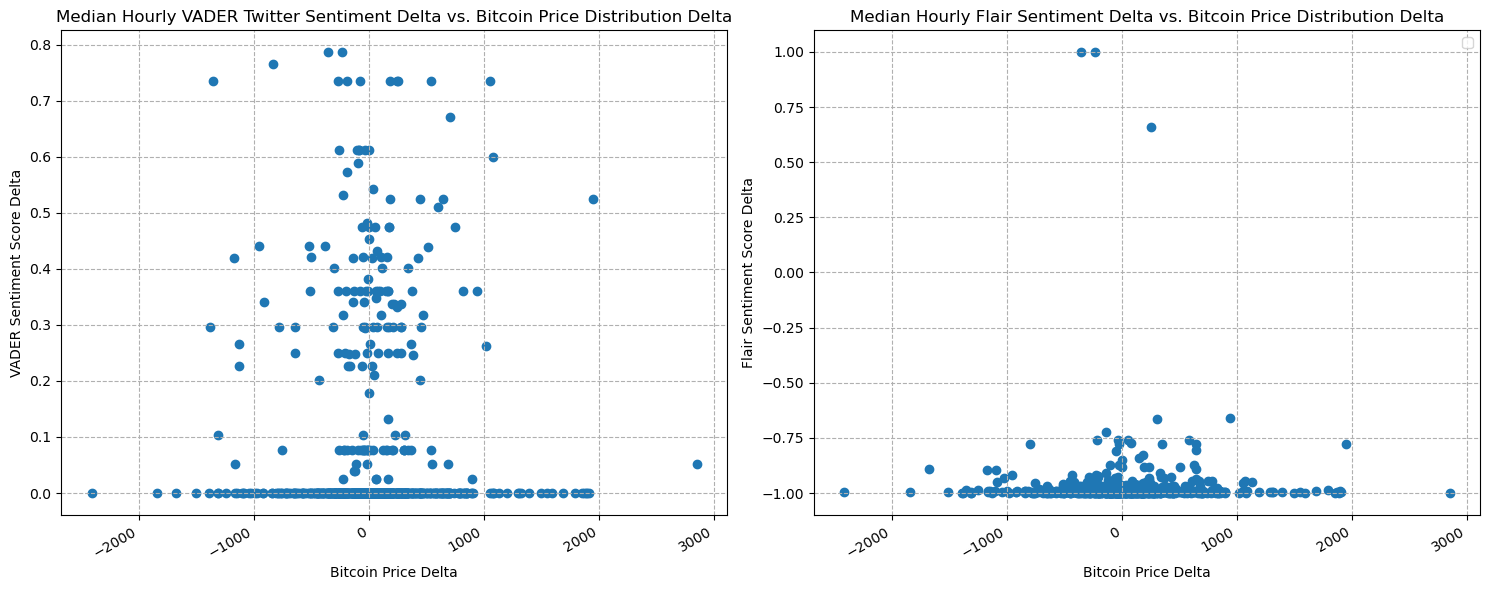

In [154]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(hr_btc_tw['price_delta'], hr_btc_tw['vd_compound'])
ax[0].set_xlabel("Bitcoin Price Delta")
ax[0].set_ylabel("VADER Sentiment Score Delta")
ax[0].set_title("Median Hourly VADER Twitter Sentiment Delta vs. Bitcoin Price Distribution Delta")

ax[1].scatter(hr_btc_tw['price_delta'], hr_btc_tw['fl_confidence'] )
ax[1].set_xlabel("Bitcoin Price Delta")
ax[1].set_ylabel("Flair Sentiment Score Delta")
ax[1].set_title("Median Hourly Flair Sentiment Delta vs. Bitcoin Price Distribution Delta")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

### Daily Mean and Median Data

In [155]:
day_btc_tw['price_delta'] = day_btc_tw['price'].diff()
day_btc_tw['fl_confidence_delta'] = day_btc_tw['fl_confidence'].diff()
day_btc_tw['vd_compound_delta'] = day_btc_tw['vd_compound'].diff()

In [156]:
day_btc_tw = day_btc_tw.dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


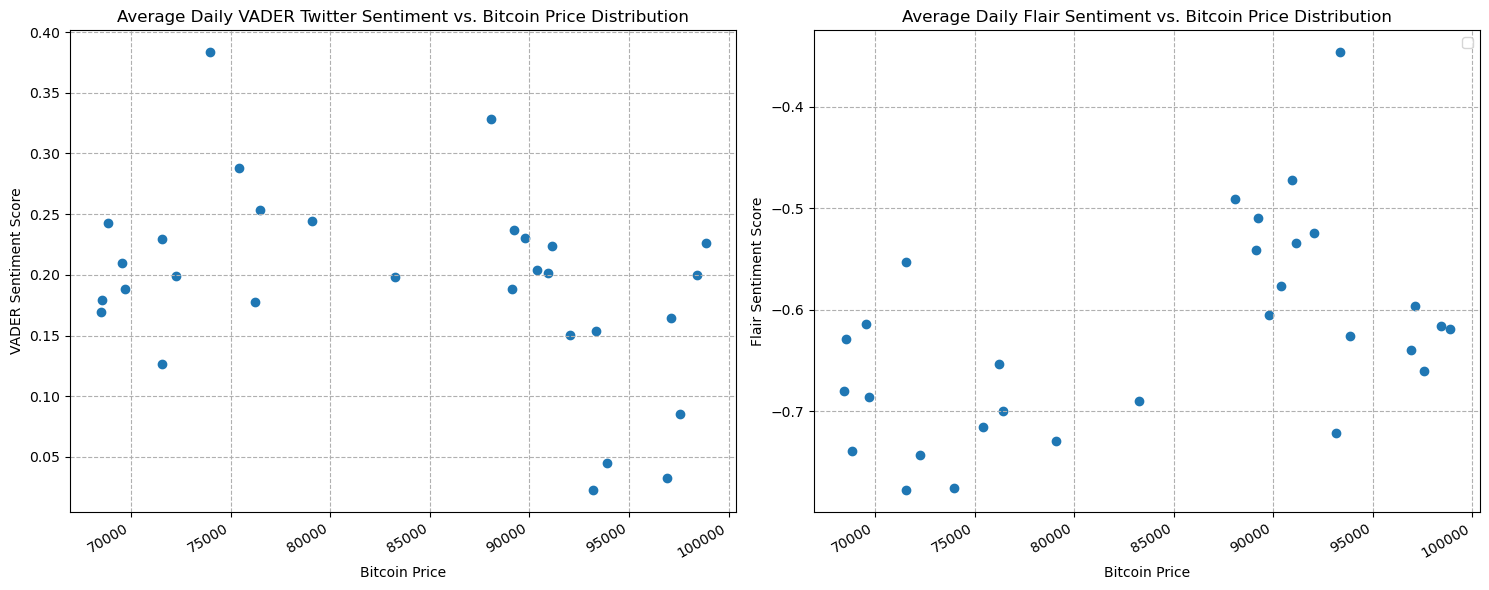

In [157]:
# Twitter sentiment vs. bitcoin price distribution 
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(day_btc_tw['price'], day_btc_tw['vd_compound'])
ax[0].set_xlabel("Bitcoin Price")
ax[0].set_ylabel("VADER Sentiment Score")
ax[0].set_title("Average Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution")

ax[1].scatter(day_btc_tw['price'], day_btc_tw['fl_confidence'] )
ax[1].set_xlabel("Bitcoin Price")
ax[1].set_ylabel("Flair Sentiment Score")
ax[1].set_title("Average Daily Flair Sentiment vs. Bitcoin Price Distribution")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


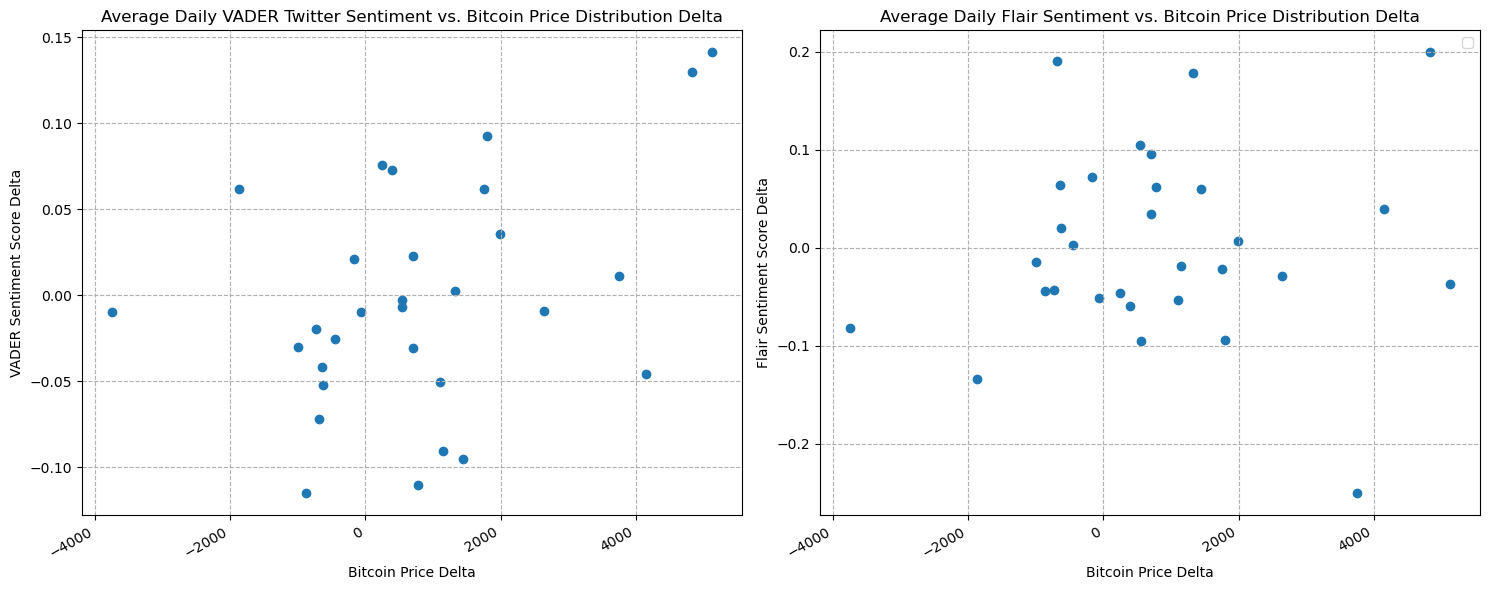

In [158]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(day_btc_tw['price_delta'], day_btc_tw['vd_compound_delta'])
ax[0].set_xlabel("Bitcoin Price Delta")
ax[0].set_ylabel("VADER Sentiment Score Delta")
ax[0].set_title("Average Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution Delta")

ax[1].scatter(day_btc_tw['price_delta'], day_btc_tw['fl_confidence_delta'] )
ax[1].set_xlabel("Bitcoin Price Delta")
ax[1].set_ylabel("Flair Sentiment Score Delta")
ax[1].set_title("Average Daily Flair Sentiment vs. Bitcoin Price Distribution Delta")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [159]:
# Merge btc_data with tw_data using sentiment median values
df = pd.merge(day_btc, v_day_med, on='time')
day_btc_tw = pd.merge(df, f_day_med, on='time')

day_btc_tw.head(5)

,time,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,MACD,Signal_Line,MACD_Histogram,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,2024-10-28,69376.60,70051.00,69732.718000,1.301950e+11,70288.00,67532.48,69356.463200,69265.223667,NaN,282.484373,156.474843,126.009530,0.0,0.0,0.889,0.0,-0.992180
1,2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418000,70980.873500,74.561607,713.869070,715.268277,-1.399207,0.0,0.0,0.889,0.0,-0.994748
2,2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347000,72298.577625,48.791275,137.377439,137.749967,-0.372528,0.0,0.0,1.000,0.0,-0.994748
3,2024-10-31,72364.69,70327.64,71554.782609,9.876689e+11,73060.00,69559.33,71717.061217,71901.077435,39.838041,-538.661435,-394.367773,-144.293662,0.0,0.0,1.000,0.0,-0.965998
4,2024-11-01,70279.98,69493.18,69687.498182,1.083267e+12,72684.02,68720.00,69750.167727,69844.018682,42.428161,-312.413866,-316.362537,3.948671,0.0,0.0,1.000,0.0,-0.998059


In [160]:
day_btc_tw['price_delta'] = day_btc_tw['price'].diff()
day_btc_tw['fl_confidence_delta'] = day_btc_tw['fl_confidence'].diff()
day_btc_tw['vd_compound_delta'] = day_btc_tw['vd_compound'].diff()

day_btc_tw = day_btc_tw.dropna()
day_btc_tw.head(5)


,time,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,...,Signal_Line,MACD_Histogram,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence,price_delta,fl_confidence_delta,vd_compound_delta
1,2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418000,70980.873500,74.561607,...,715.268277,-1.399207,0.0,0.0,0.889,0.0,-0.994748,1804.582417,-0.002568,0.0
2,2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347000,72298.577625,48.791275,...,137.749967,-0.372528,0.0,0.0,1.000,0.0,-0.994748,703.530000,0.000000,0.0
3,2024-10-31,72364.69,70327.64,71554.782609,9.876689e+11,73060.00,69559.33,71717.061217,71901.077435,39.838041,...,-394.367773,-144.293662,0.0,0.0,1.000,0.0,-0.965998,-686.047808,0.028750,0.0
4,2024-11-01,70279.98,69493.18,69687.498182,1.083267e+12,72684.02,68720.00,69750.167727,69844.018682,42.428161,...,-316.362537,3.948671,0.0,0.0,1.000,0.0,-0.998059,-1867.284427,-0.032061,0.0
5,2024-11-02,69662.00,69275.84,69523.744167,9.272945e+11,71653.00,68720.00,69522.134167,69519.826042,46.652297,...,-116.770862,12.360056,0.0,0.0,1.000,0.0,-0.995551,-163.754015,0.002508,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


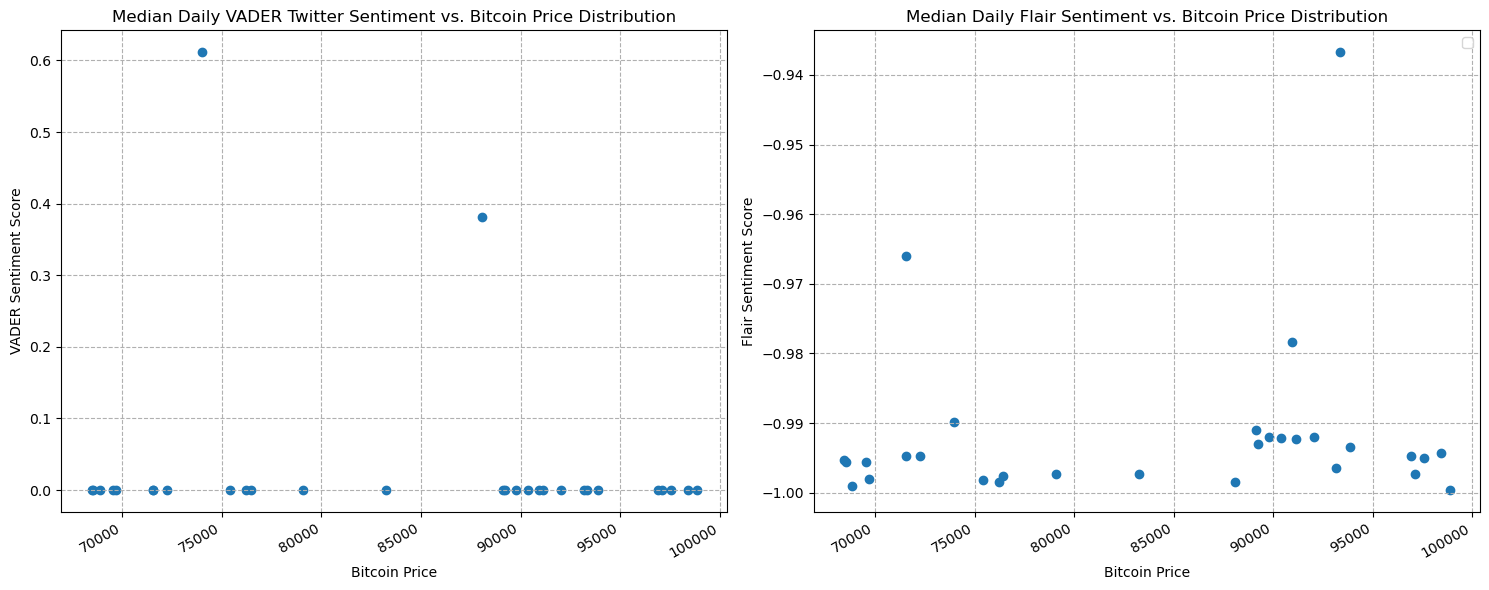

In [161]:
# Twitter sentiment vs. bitcoin price distribution 
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(day_btc_tw['price'], day_btc_tw['vd_compound'])
ax[0].set_xlabel("Bitcoin Price")
ax[0].set_ylabel("VADER Sentiment Score")
ax[0].set_title("Median Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution")

ax[1].scatter(day_btc_tw['price'], day_btc_tw['fl_confidence'] )
ax[1].set_xlabel("Bitcoin Price")
ax[1].set_ylabel("Flair Sentiment Score")
ax[1].set_title("Median Daily Flair Sentiment vs. Bitcoin Price Distribution")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


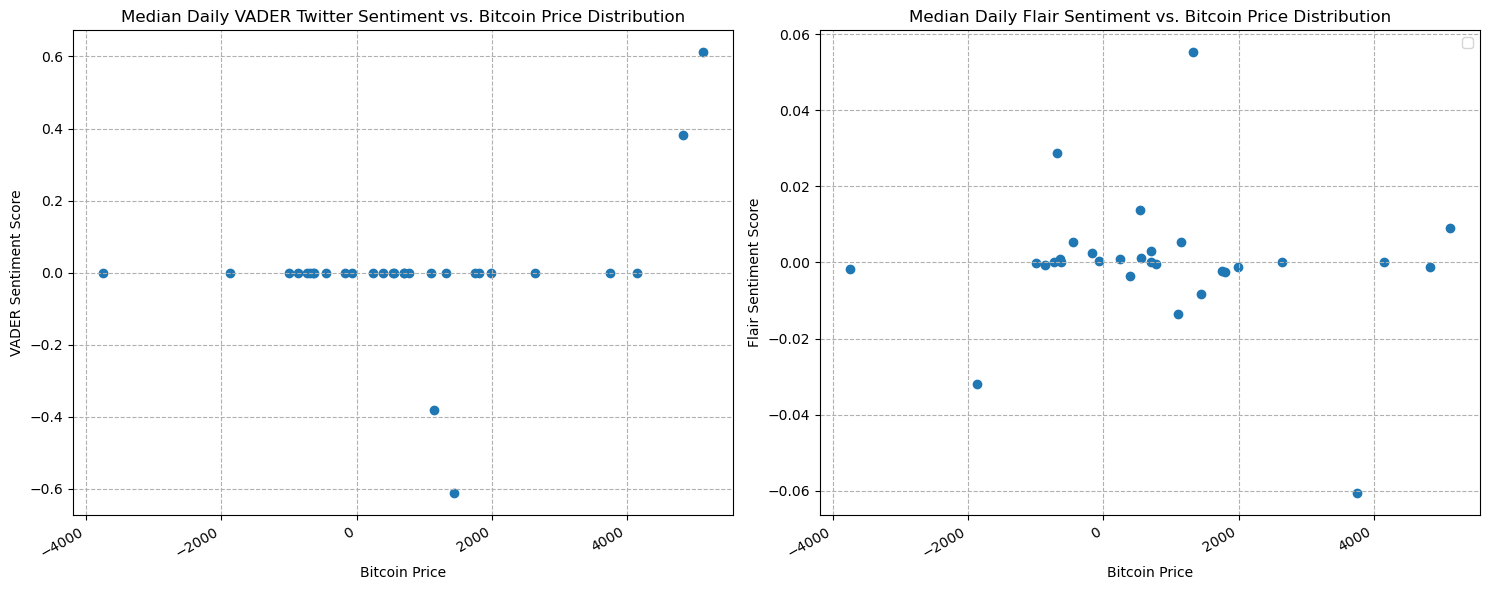

In [162]:
# Twitter sentiment vs. bitcoin price distribution 
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(day_btc_tw['price_delta'], day_btc_tw['vd_compound_delta'])
ax[0].set_xlabel("Bitcoin Price")
ax[0].set_ylabel("VADER Sentiment Score")
ax[0].set_title("Median Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution")

ax[1].scatter(day_btc_tw['price_delta'], day_btc_tw['fl_confidence_delta'] )
ax[1].set_xlabel("Bitcoin Price")
ax[1].set_ylabel("Flair Sentiment Score")
ax[1].set_title("Median Daily Flair Sentiment vs. Bitcoin Price Distribution")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

## Daily Max/Min Price Values VS. Daily Twitter Sentiment 

In [163]:
# Daily high 
btc_day_high = btc_data.groupby(
  btc_data['time'].dt.floor('d')
  )[['dayHigh']].max().reset_index()

btc_day_high.head(5)

,time,dayHigh
0,2024-10-28,70288.00
1,2024-10-29,73624.98
2,2024-10-30,73624.98
3,2024-10-31,73060.00
4,2024-11-01,72684.02


In [164]:
# Merge btc_data with tw_data using sentiment mean values
df = pd.merge(btc_day_high, v_day_mean, on='time')
day_btc_tw = pd.merge(df, f_day_mean, on='time')

day_btc_tw.head(5)

,time,dayHigh,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,2024-10-28,70288.00,0.084480,0.032990,0.882500,0.137509,-0.683241
1,2024-10-29,73624.98,0.087436,0.020728,0.891824,0.229950,-0.777407
2,2024-10-30,73624.98,0.078708,0.015728,0.905576,0.199071,-0.742708
3,2024-10-31,73060.00,0.066368,0.030445,0.903187,0.126812,-0.552631
4,2024-11-01,72684.02,0.080500,0.029864,0.889636,0.188688,-0.686260


In [165]:
day_btc_tw['dayHigh_delta'] = day_btc_tw['dayHigh'].diff()
day_btc_tw['fl_confidence_delta'] = day_btc_tw['fl_confidence'].diff()
day_btc_tw['vd_compound_delta'] = day_btc_tw['vd_compound'].diff()

day_btc_tw = day_btc_tw.dropna()
day_btc_tw.head(5)

,time,dayHigh,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence,dayHigh_delta,fl_confidence_delta,vd_compound_delta
1,2024-10-29,73624.98,0.087436,0.020728,0.891824,0.229950,-0.777407,3336.98,-0.094166,0.092441
2,2024-10-30,73624.98,0.078708,0.015728,0.905576,0.199071,-0.742708,0.00,0.034699,-0.030879
3,2024-10-31,73060.00,0.066368,0.030445,0.903187,0.126812,-0.552631,-564.98,0.190076,-0.072259
4,2024-11-01,72684.02,0.080500,0.029864,0.889636,0.188688,-0.686260,-375.98,-0.133629,0.061876
5,2024-11-02,71653.00,0.088366,0.022634,0.888980,0.209704,-0.614160,-1031.02,0.072100,0.021015


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


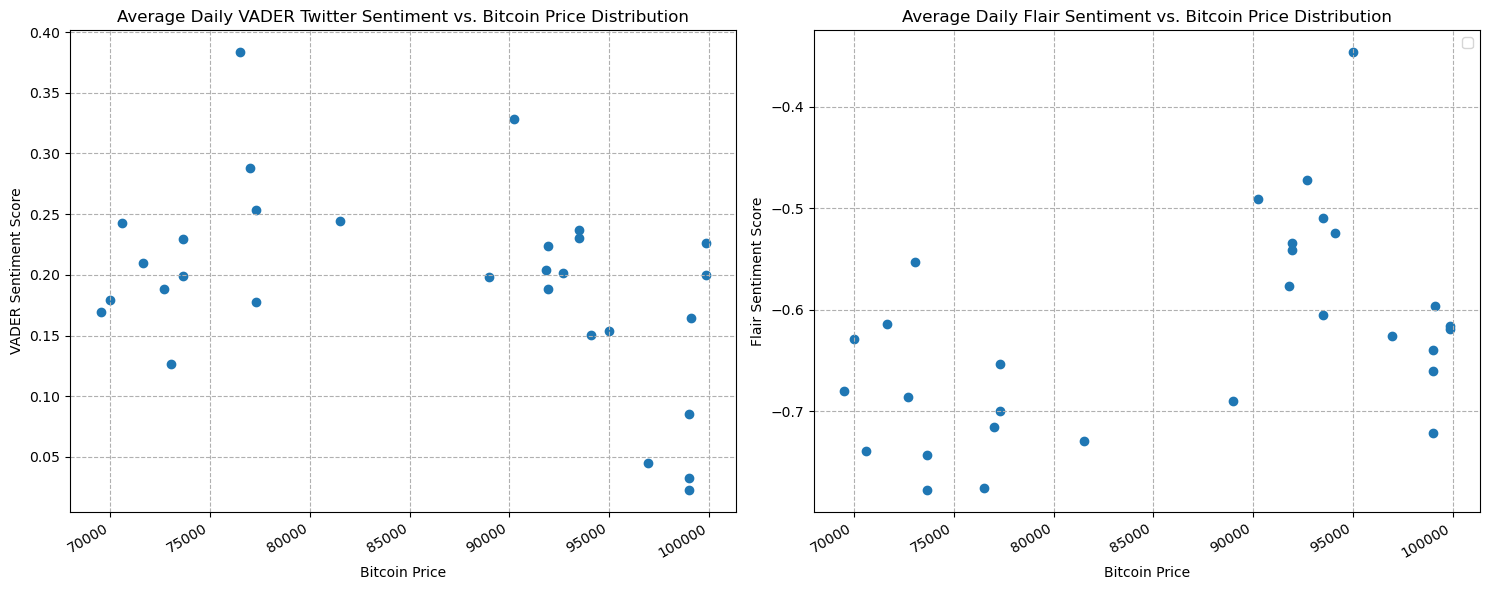

In [166]:
# Twitter sentiment vs. bitcoin price distribution 
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(day_btc_tw['dayHigh'], day_btc_tw['vd_compound'])
ax[0].set_xlabel("Bitcoin Price")
ax[0].set_ylabel("VADER Sentiment Score")
ax[0].set_title("Average Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution")

ax[1].scatter(day_btc_tw['dayHigh'], day_btc_tw['fl_confidence'] )
ax[1].set_xlabel("Bitcoin Price")
ax[1].set_ylabel("Flair Sentiment Score")
ax[1].set_title("Average Daily Flair Sentiment vs. Bitcoin Price Distribution")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


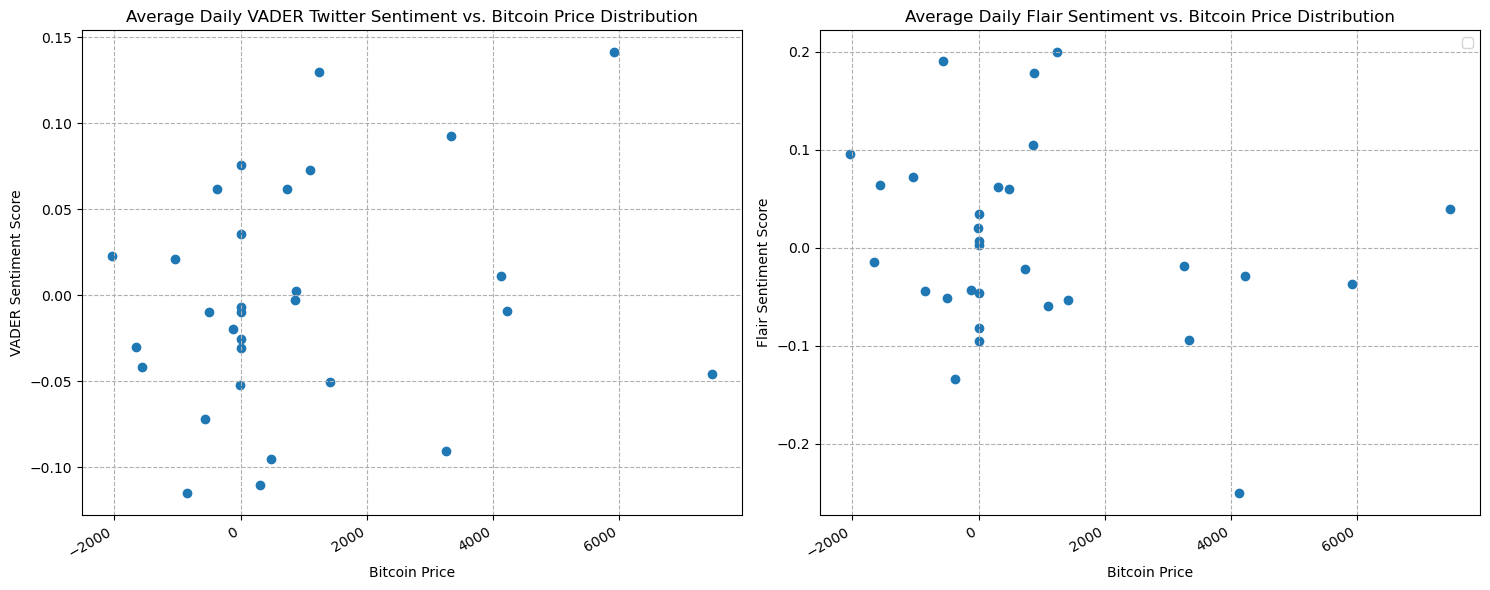

In [167]:
# Twitter sentiment vs. bitcoin price distribution 
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(day_btc_tw['dayHigh_delta'], day_btc_tw['vd_compound_delta'])
ax[0].set_xlabel("Bitcoin Price")
ax[0].set_ylabel("VADER Sentiment Score")
ax[0].set_title("Average Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution")

ax[1].scatter(day_btc_tw['dayHigh_delta'], day_btc_tw['fl_confidence_delta'] )
ax[1].set_xlabel("Bitcoin Price")
ax[1].set_ylabel("Flair Sentiment Score")
ax[1].set_title("Average Daily Flair Sentiment vs. Bitcoin Price Distribution")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

## III Random Forest Prediction with daily data

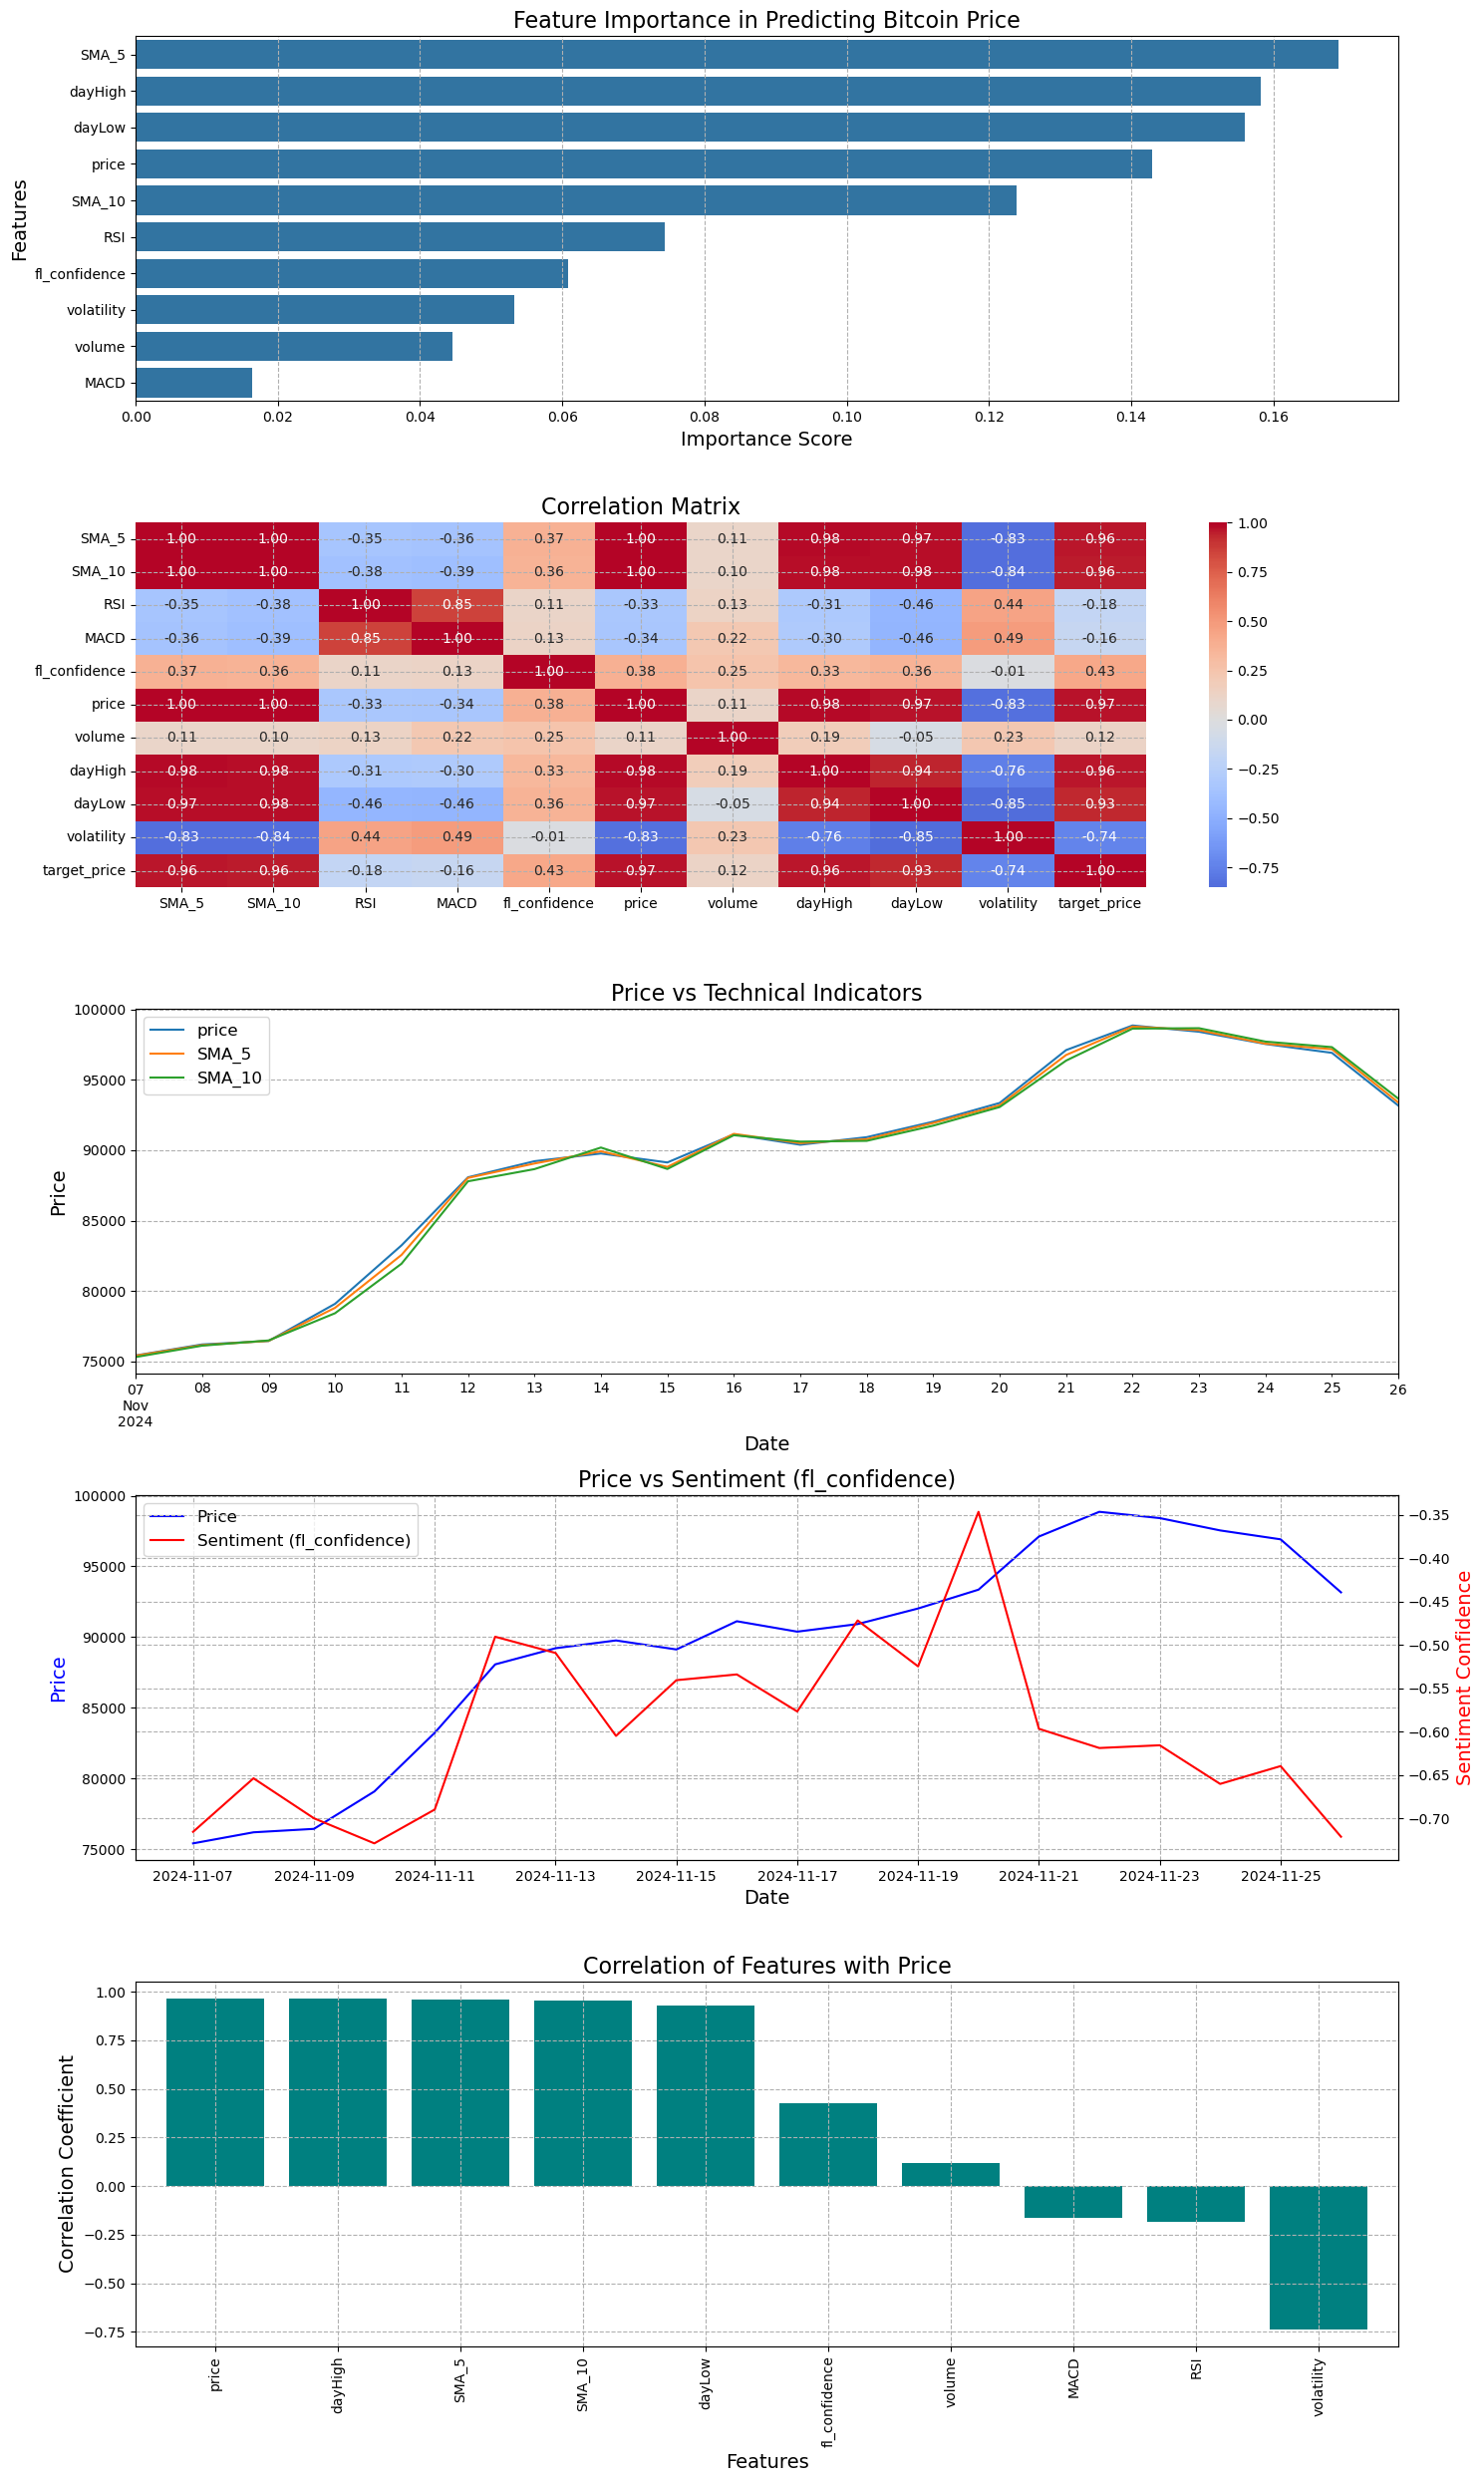


1. Feature Group Importance:
Technical Indicators: 0.3840
Sentiment Features: 0.0609
Price Features: 0.5552

2. Model Performance:
RMSE: 4977.80
R² Score: 0.7830

3. Correlation with Price:
target_price     1.000000
price            0.966861
dayHigh          0.963642
SMA_5            0.960966
SMA_10           0.955140
dayLow           0.930674
fl_confidence    0.427864
volume           0.120227
MACD            -0.163077
RSI             -0.183197
volatility      -0.739572
Name: target_price, dtype: float64


In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('day_btc_tw.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Feature sets
technical_features = ['SMA_5', 'SMA_10', 'RSI', 'MACD']
sentiment_features = ['fl_confidence']
price_features = ['price','volume', 'dayHigh', 'dayLow']

# Add volatility as a feature
df['volatility'] = df['price'].pct_change().rolling(window=10).std() * 100  # Rolling std dev of price changes

# Combine features and target
X = df[technical_features + sentiment_features + price_features + ['volatility']].copy()
y = df['price'].shift(-1)  # Predict next day's price

# Remove NaN values from both X and y
df_clean = pd.concat([X, y.rename('target_price')], axis=1).dropna()

# Ensure 'price' is a single Series
if isinstance(df_clean['price'], pd.DataFrame):
    df_clean['price'] = df_clean['price'].iloc[:, 0]  # Select the first column


# Split data for machine learning
X = df_clean[technical_features + sentiment_features + price_features + ['volatility']]
y = df_clean['target_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 25))

# 1. Feature Importance Plot
plt.subplot(5, 1, 1)
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Bitcoin Price', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()

# 2. Correlation Matrix Heatmap
correlation_matrix = df_clean.corr()
plt.subplot(5, 1, 2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()

# 3. Price vs Technical Indicators
plt.subplot(5, 1, 3)
df_clean[['price', 'SMA_5', 'SMA_10']].plot(ax=plt.gca())
plt.title('Price vs Technical Indicators', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# 4. Sentiment (fl_confidence) vs Price
plt.subplot(5, 1, 4)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(df_clean.index, df_clean['price'], color='blue', label='Price')
ax2.plot(df_clean.index, df_clean['fl_confidence'], color='red', label='Sentiment (fl_confidence)')
plt.title('Price vs Sentiment (fl_confidence)', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Price', fontsize=14, color='blue')
ax2.set_ylabel('Sentiment Confidence', fontsize=14, color='red')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)
plt.tight_layout()

# 5. Correlation of Features with Price
plt.subplot(5, 1, 5)
price_correlations = correlation_matrix['target_price'].sort_values(ascending=False)
price_correlations.drop('target_price').plot(kind='bar', color='teal', width=0.8)
plt.title('Correlation of Features with Price', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.tight_layout()

plt.show()

# Print Results

print("\n1. Feature Group Importance:")
tech_importance = feature_importance[feature_importance['feature'].isin(technical_features)]['importance'].sum()
sentiment_importance = feature_importance[feature_importance['feature'].isin(sentiment_features)]['importance'].sum()
price_importance = feature_importance[feature_importance['feature'].isin(price_features + ['volatility'])]['importance'].sum()
print(f"Technical Indicators: {tech_importance:.4f}")
print(f"Sentiment Features: {sentiment_importance:.4f}")
print(f"Price Features: {price_importance:.4f}")

print("\n2. Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

print("\n3. Correlation with Price:")
print(price_correlations)
